<div style="text-align: center;">
<h1>Cinematic ROI and Audience Dynamics:<br />
Financial Efficiency, Genre Fatigue, and Global Film Trends</h1>
</div>

<hr />
<p><span style="font-weight: bold;">Overview:</span><br />
This project analyzes the <a href="https://www.kaggle.com/datasets/mustafasayed1181/movies-metadata-cleaned-dataset-19002025/" target=_blank>Movies Metadata Cleaned Dataset (1900–2025)</a>, a large scale collection of over 946,000 films sourced from <a href="https://www.themoviedb.org/" target=_blank>The Movie Database (TMDB)</a>. Using variables such as budget, revenue, genres, countries, languages, popularity, and ratings, the study examines three analytical issues:
<ol><li>How production budgets translate into financial efficiency and return on investment (ROI).</li>
<li>How movie attributes relate to audience reception and popularity.</li>
<li>How inflation adjusted financial performance and genre level fatigue have evolved across decades and regions.</li></ol></p> 
<p>The goal is to identify budget sweet spots, quantify potential diminishing returns and genre saturation, and map long term shifts in global film success.</p>

<p><span style="font-weight: bold;">Research Questions</span>
    <ul>
        <li>Once we adjust for inflation, do small indie films, mid-sized movies, or massive blockbusters make the most profit relative to their cost?</li>
        <li>Is there a limit to how much money a studio should spend?</li>
        <li>How do things like a movie’s genre, length, or language affect how many people watch it and how much they like it? Do big-name studios and high budgets automatically guarantee a movie will be popular?</li>
        <li>How have things like runtime and profits changed across the decades and between different countries?</li>
        <li>Does genre fatigue exist? Does releasing too many movies of the same type cause ratings to crash?</li>
    </ul>
</p>
<hr />

<!-- In your pursuit of researching genre saturation, I would be interested in seeing a visualization of how many of each film type was produced each year if you have time. -->

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import ast, re
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

from collections import Counter
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# Reproducibility
SEED = 42
np.random.seed(SEED)

PALETTE = ['#66c2a5', '#fc8d62', '#8da0cb']
PALETTE2 = ["#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854",
           "#ffd92f","#e5c494","#b3b3b3","#1f78b4","#33a02c"]

In [2]:
display(Markdown("## Exploratory Data Analysis"))

# Load dataset
df = pd.read_excel('../dataset/data_movies_clean.xlsx')  
# Reads the dataset from the specified file path into a Pandas DataFrame named `df`.

# Basic info
display(Markdown("**Shape:**"))
print(df.shape)  # displays number of rows (observations) and columns (features) in the dataset
print()

# View first 5 rows
display(Markdown("**First five rows:**"))
print(df.head())  # displays the first 5 rows
print()

# View dataset statistics
display(Markdown("**Summary Statistics:**"))
summary_stats = df.describe().round(2).T
display(summary_stats) # prints summary statistics (count, mean, standard deviation, min, max, and quartiles) for numerical columns

display(Markdown("**Info:**"))
df.info()  # displays the number of records in each column, type of data, whether any values are missing, and how much memory the dataset uses
print()

df.columns.tolist()  # converts the column names into a Python list

## Exploratory Data Analysis

**Shape:**

(946460, 14)



**First five rows:**

       id                                     title  adult original_language  \
0  195554         Panorama of Galveston Power House  False                en   
1  105303                  Explosion of a Motor Car  False                xx   
2  195553      Panorama of Orphans' Home, Galveston  False                en   
3  195569       Panorama of Wreckage of Water Front  False                en   
4  195542  Bird's-Eye View of Dock Front, Galveston  False                en   

  origin_country release_date      genre_names production_company_names  \
0         ['US']   1900-05-21               []                       []   
1         ['GB']   1900-07-01       ['Comedy']             ['Hepworth']   
2         ['US']   1900-09-21               []                       []   
3         ['US']   1900-09-21  ['Documentary']       ['Edison Studios']   
4         ['US']   1900-09-21  ['Documentary']       ['Edison Studios']   

        budget      revenue  runtime  popularity  vote_average  vote

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
id,946460.0,757921.82,439188.61,2.0,386568.25,735737.50,1139082.25,1.554339e+06
budget,946460.0,8051662.04,13144473.45,1.0,445172.59,2286012.61,10090933.30,5.839000e+08
revenue,946460.0,7581762.45,21072294.24,-12.0,1741077.79,3052453.20,7600000.00,2.923706e+09
runtime,946460.0,47.21,54.92,0.0,5.00,29.00,88.00,1.440000e+04
popularity,946460.0,0.79,1.94,0.0,0.03,0.17,1.08,7.421100e+02
vote_average,946460.0,2.33,3.13,0.0,0.00,0.00,5.40,1.000000e+01
vote_count,946460.0,26.99,395.19,0.0,0.00,0.00,2.00,3.799500e+04


**Info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946460 entries, 0 to 946459
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        946460 non-null  int64  
 1   title                     946451 non-null  object 
 2   adult                     946460 non-null  bool   
 3   original_language         946460 non-null  object 
 4   origin_country            946460 non-null  object 
 5   release_date              946460 non-null  object 
 6   genre_names               946460 non-null  object 
 7   production_company_names  946460 non-null  object 
 8   budget                    946460 non-null  float64
 9   revenue                   946460 non-null  float64
 10  runtime                   946460 non-null  int64  
 11  popularity                946460 non-null  float64
 12  vote_average              946460 non-null  float64
 13  vote_count                946460 non-null  i

['id',
 'title',
 'adult',
 'original_language',
 'origin_country',
 'release_date',
 'genre_names',
 'production_company_names',
 'budget',
 'revenue',
 'runtime',
 'popularity',
 'vote_average',
 'vote_count']

<hr />
<h2>Data Preprocessing</h2>
<span style="font-size: 1.1em;">
    <ul>
        <li>I want to start by eliminating shorts from the dataset and focusing only on feature-length films (over 60 mins).</li>
        <li>During the 1930s, cinema became the principal form of popular entertainment, with nearly all feature-length movies using synchronized sound. This marked the start of Hollywood’s widely recognized "Golden Age," when the big studios were producing large numbers of mainstream, narrative features that set many of today’s industrial and stylistic norms. For this project, I will limit my dataset to films from 1930-2025.</li>
    </ul>
</span>

<p>Heckman, C. (2023, January 1). <span style="font-style: italic;">The history of film timeline — All eras of film history explained.</span> studiobinder. <a href="https://www.studiobinder.com/blog/the-history-of-film-timeline/" target=_blank>https://www.studiobinder.com/blog/the-history-of-film-timeline/</a></p>
<hr />

In [3]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

# Filter results to release_date after 1929 and runtime > 60 mins
df = df[(df['release_date'] > '1929-12-31') & (df['runtime'] > 60)]

# NEW Shape info
display(Markdown("**New Shape:**"))
print(df.shape)  # displays number of rows (observations) and columns (features) in the dataset
print()

# View first 5 rows
display(Markdown("**First five rows:**"))
print(df.head())  # displays the first 5 rows
print()

# View dataset statistics
display(Markdown("**Summary Statistics:**"))
summary_stats = df.describe().round(2).T
display(summary_stats) # prints summary statistics (count, mean, standard deviation, min, max, and quartiles) for numerical columns

display(Markdown("**Info:**"))
df.info()  # displays the number of records in each column, type of data, whether any values are missing, and how much memory the dataset uses
print()

**New Shape:**

(370118, 14)



**First five rows:**

           id               title  adult original_language origin_country  \
33231  584062        The Sea Wolf  False                en         ['US']   
33233  586022  The Land of Smiles  False                de         ['DE']   
33234  353152      The Great Game  False                en         ['GB']   
33236  305990     Forgotten Women  False                en         ['US']   
33237   84277          East Lynne  False                en         ['US']   

      release_date  genre_names                 production_company_names  \
33231   1930-09-21  ['Romance']                                       []   
33233   1930-03-14    ['Music']                                       []   
33234   1930-08-27   ['Comedy']  ['Gaumont-British Picture Corporation']   
33236   1931-11-25    ['Drama']                     ['Liberty Pictures']   
33237   1931-03-01    ['Drama']                 ['Fox Film Corporation']   

             budget        revenue  runtime  popularity  vote_average  \
33231  

**Summary Statistics:**

,count,mean,min,25%,50%,75%,max,std
id,370118.0,570449.82,2.0,220587.75,482522.0,881705.25,1554304.0,424499.17
release_date,370118,1999-12-09 19:37:11.191133184,1930-01-01 00:00:00,1986-01-01 00:00:00,2008-07-04 00:00:00,2018-06-08 00:00:00,2025-12-31 00:00:00,NaN
budget,370118.0,7393548.1,1.0,545278.39,2559017.2,9360271.73,583900000.0,13078483.02
revenue,370118.0,8199181.95,0.56,1785141.07,2754472.37,6997819.45,2923706026.0,30934647.65
runtime,370118.0,97.62,61.0,82.0,91.0,105.0,14400.0,54.34
popularity,370118.0,1.37,0.0,0.17,0.84,2.18,742.11,2.82
vote_average,370118.0,3.57,0.0,0.0,4.5,6.1,10.0,3.08
vote_count,370118.0,66.92,0.0,0.0,1.0,8.0,37995.0,629.51


**Info:**

<class 'pandas.core.frame.DataFrame'>
Index: 370118 entries, 33231 to 946457
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        370118 non-null  int64         
 1   title                     370115 non-null  object        
 2   adult                     370118 non-null  bool          
 3   original_language         370118 non-null  object        
 4   origin_country            370118 non-null  object        
 5   release_date              370118 non-null  datetime64[ns]
 6   genre_names               370118 non-null  object        
 7   production_company_names  370118 non-null  object        
 8   budget                    370118 non-null  float64       
 9   revenue                   370118 non-null  float64       
 10  runtime                   370118 non-null  int64         
 11  popularity                370118 non-null  float64       
 12  vot

<hr />
<span style="font-size: 1.1em;">
    <ul>
        <li>To adjust for inflation, I will calculate budgets and revenues in today’s money.</li>
        <ul>
            <li>Using the <a href="https://www.bls.gov/cpi/" target=_blank>Consumer Price Index (CPI)</a> from the US Bureau of Labor Statistics (BLS) for 1997-2025</li>
            <li>And <a href="https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-" tatget=_blank>historical CPI from the Federal Reserve bank of Minneapolis</a> for dates before 1997.</li>
        </ul>
    </ul>
</span>
<hr />

In [4]:
# Load modern CPI (1997+) from BLS flat file
cpi_raw = pd.read_csv("../dataset/cu.data.0.Current", sep="\t")

# fix column names
cpi_raw.columns = cpi_raw.columns.str.strip()

# strip whitespace from series_id
cpi_raw["series_id"] = cpi_raw["series_id"].str.strip()

# filter and process modern CPI
series_modern = "CUSR0000SA0"
cpi_modern_raw = cpi_raw[cpi_raw["series_id"] == series_modern].copy()
cpi_modern_raw["value"] = pd.to_numeric(cpi_modern_raw["value"], errors="coerce")

cpi_modern = (
    cpi_modern_raw[cpi_modern_raw["period"].str.startswith("M")]
    .groupby("year", as_index=False)["value"]
    .mean()
    .rename(columns={"value": "cpi"})
    .round(3)
)

# Load historical CPI (1913–1996)
cpi_historical = pd.read_csv("../dataset/cpi_1913.csv")

# Rename columns to match (drop Annual Percent Change column)
if "Annual Percent Change" in cpi_historical.columns:
    cpi_historical = cpi_historical[["Year", "CPI"]].rename(columns={"Year": "year", "CPI": "cpi"})
else:
    cpi_historical = cpi_historical.rename(columns={"Year": "year", "CPI": "cpi"})

cpi_historical["cpi"] = cpi_historical["cpi"].round(3)

# Combine both CPI datasets
cpi_full = pd.concat([cpi_historical, cpi_modern], ignore_index=True)
cpi_full = cpi_full.sort_values("year").drop_duplicates("year").reset_index(drop=True)


# Merge with movies dataframe and create inflation columns
df["release_year"] = pd.to_datetime(df["release_date"], errors="coerce").dt.year.astype("Int64")

df_cpi_merged = df.merge(cpi_full, left_on="release_year", right_on="year", how="left")
df_cpi_merged.drop(columns=["year"], inplace=True)

# Create inflation adjustment columns (2025 dollars)
base_year = 2025
base_cpi = cpi_full.loc[cpi_full["year"] == base_year, "cpi"].iloc[0]

df_cpi_merged["inflation_factor"] = base_cpi / df_cpi_merged["cpi"]
df_cpi_merged["budget_adj"] = df_cpi_merged["budget"] * df_cpi_merged["inflation_factor"]
df_cpi_merged["revenue_adj"] = df_cpi_merged["revenue"] * df_cpi_merged["inflation_factor"]
df_cpi_merged["profit_adj"] = df_cpi_merged["revenue_adj"] - df_cpi_merged["budget_adj"]

# Copy all back to original dataframe name
df = df_cpi_merged

# Verify
display(Markdown("#### Inflation adjustments complete"))
display(Markdown(f"**Adjusted movies (1930-2025):** {df['budget_adj'].notna().sum():,} / {len(df):,}"))

# View first 5 rows
display(Markdown("**First five rows:**"))
print(df.head())  # displays the first 5 rows
print()

# View dataset statistics
display(Markdown("**Summary Statistics:**"))
summary_stats = df.describe().round(2).T
display(summary_stats) # prints summary statistics (count, mean, standard deviation, min, max, and quartiles) for numerical columns

display(Markdown("**Info:**"))
df.info()  # displays the number of records in each column, type of data, whether any values are missing, and how much memory the dataset uses
print()

#### Inflation adjustments complete

**Adjusted movies (1930-2025):** 370,118 / 370,118

**First five rows:**

       id               title  adult original_language origin_country  \
0  584062        The Sea Wolf  False                en         ['US']   
1  586022  The Land of Smiles  False                de         ['DE']   
2  353152      The Great Game  False                en         ['GB']   
3  305990     Forgotten Women  False                en         ['US']   
4   84277          East Lynne  False                en         ['US']   

  release_date  genre_names                 production_company_names  \
0   1930-09-21  ['Romance']                                       []   
1   1930-03-14    ['Music']                                       []   
2   1930-08-27   ['Comedy']  ['Gaumont-British Picture Corporation']   
3   1931-11-25    ['Drama']                     ['Liberty Pictures']   
4   1931-03-01    ['Drama']                 ['Fox Film Corporation']   

         budget        revenue  ...  popularity  vote_average  vote_count  \
0  64011.894238   65445.474301  ...      7.6608    

**Summary Statistics:**

,count,mean,min,25%,50%,75%,max,std
id,370118.0,570449.82,2.0,220587.75,482522.0,881705.25,1554304.0,424499.17
release_date,370118,1999-12-09 19:37:11.191133184,1930-01-01 00:00:00,1986-01-01 00:00:00,2008-07-04 00:00:00,2018-06-08 00:00:00,2025-12-31 00:00:00,NaN
budget,370118.0,7393548.1,1.0,545278.39,2559017.2,9360271.73,583900000.0,13078483.02
revenue,370118.0,8199181.95,0.56,1785141.07,2754472.37,6997819.45,2923706026.0,30934647.65
runtime,370118.0,97.62,61.0,82.0,91.0,105.0,14400.0,54.34
popularity,370118.0,1.37,0.0,0.17,0.84,2.18,742.11,2.82
vote_average,370118.0,3.57,0.0,0.0,4.5,6.1,10.0,3.08
vote_count,370118.0,66.92,0.0,0.0,1.0,8.0,37995.0,629.51
release_year,370118.0,1999.46,1930.0,1986.0,2008.0,2018.0,2025.0,23.54
cpi,370118.0,182.65,12.9,109.6,214.5,251.1,321.9,92.93


**Info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370118 entries, 0 to 370117
Data columns (total 21 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   id                                         370118 non-null  int64         
 1   title                                      370115 non-null  object        
 2   adult                                      370118 non-null  bool          
 3   original_language                          370118 non-null  object        
 4   origin_country                             370118 non-null  object        
 5   release_date                               370118 non-null  datetime64[ns]
 6   genre_names                                370118 non-null  object        
 7   production_company_names                   370118 non-null  object        
 8   budget                                     370118 non-null  float64       
 9   reve

<hr />
<h2>Univariate Analysis</h2>
<p>Univariate Analysis is a type of data visualization where we visualize only a single variable at a time. Univariate Analysis helps us to analyze the distribution of the variable present in the data so that we can perform further analysis. - <a href="https://www.geeksforgeeks.org/data-visualization/what-is-univariate-bivariate-multivariate-analysis-in-data-visualisation/" target=_blank>GeeksforGeeks</a></p>
<hr />

Analyzing 7 numerical features

**Summary Statistics:**

,count,mean,std,min,25%,50%,75%,max
runtime,370118.0,97.62,54.34,6.100000e+01,82.00,91.00,105.00,1.440000e+04
popularity,370118.0,1.37,2.82,0.000000e+00,0.17,0.84,2.18,7.421100e+02
vote_average,370118.0,3.57,3.08,0.000000e+00,0.00,4.50,6.10,1.000000e+01
vote_count,370118.0,66.92,629.51,0.000000e+00,0.00,1.00,8.00,3.799500e+04
budget_adj,370118.0,12095359.60,19219574.24,1.000000e+00,1835495.37,5037299.06,14754375.98,9.250000e+08
revenue_adj,370118.0,16114449.55,55849810.19,6.000000e-01,3041227.78,7561579.67,17327230.85,9.317791e+09
profit_adj,370118.0,4019089.95,49140796.20,-4.152365e+08,-3689956.32,510475.32,4400346.96,9.225158e+09


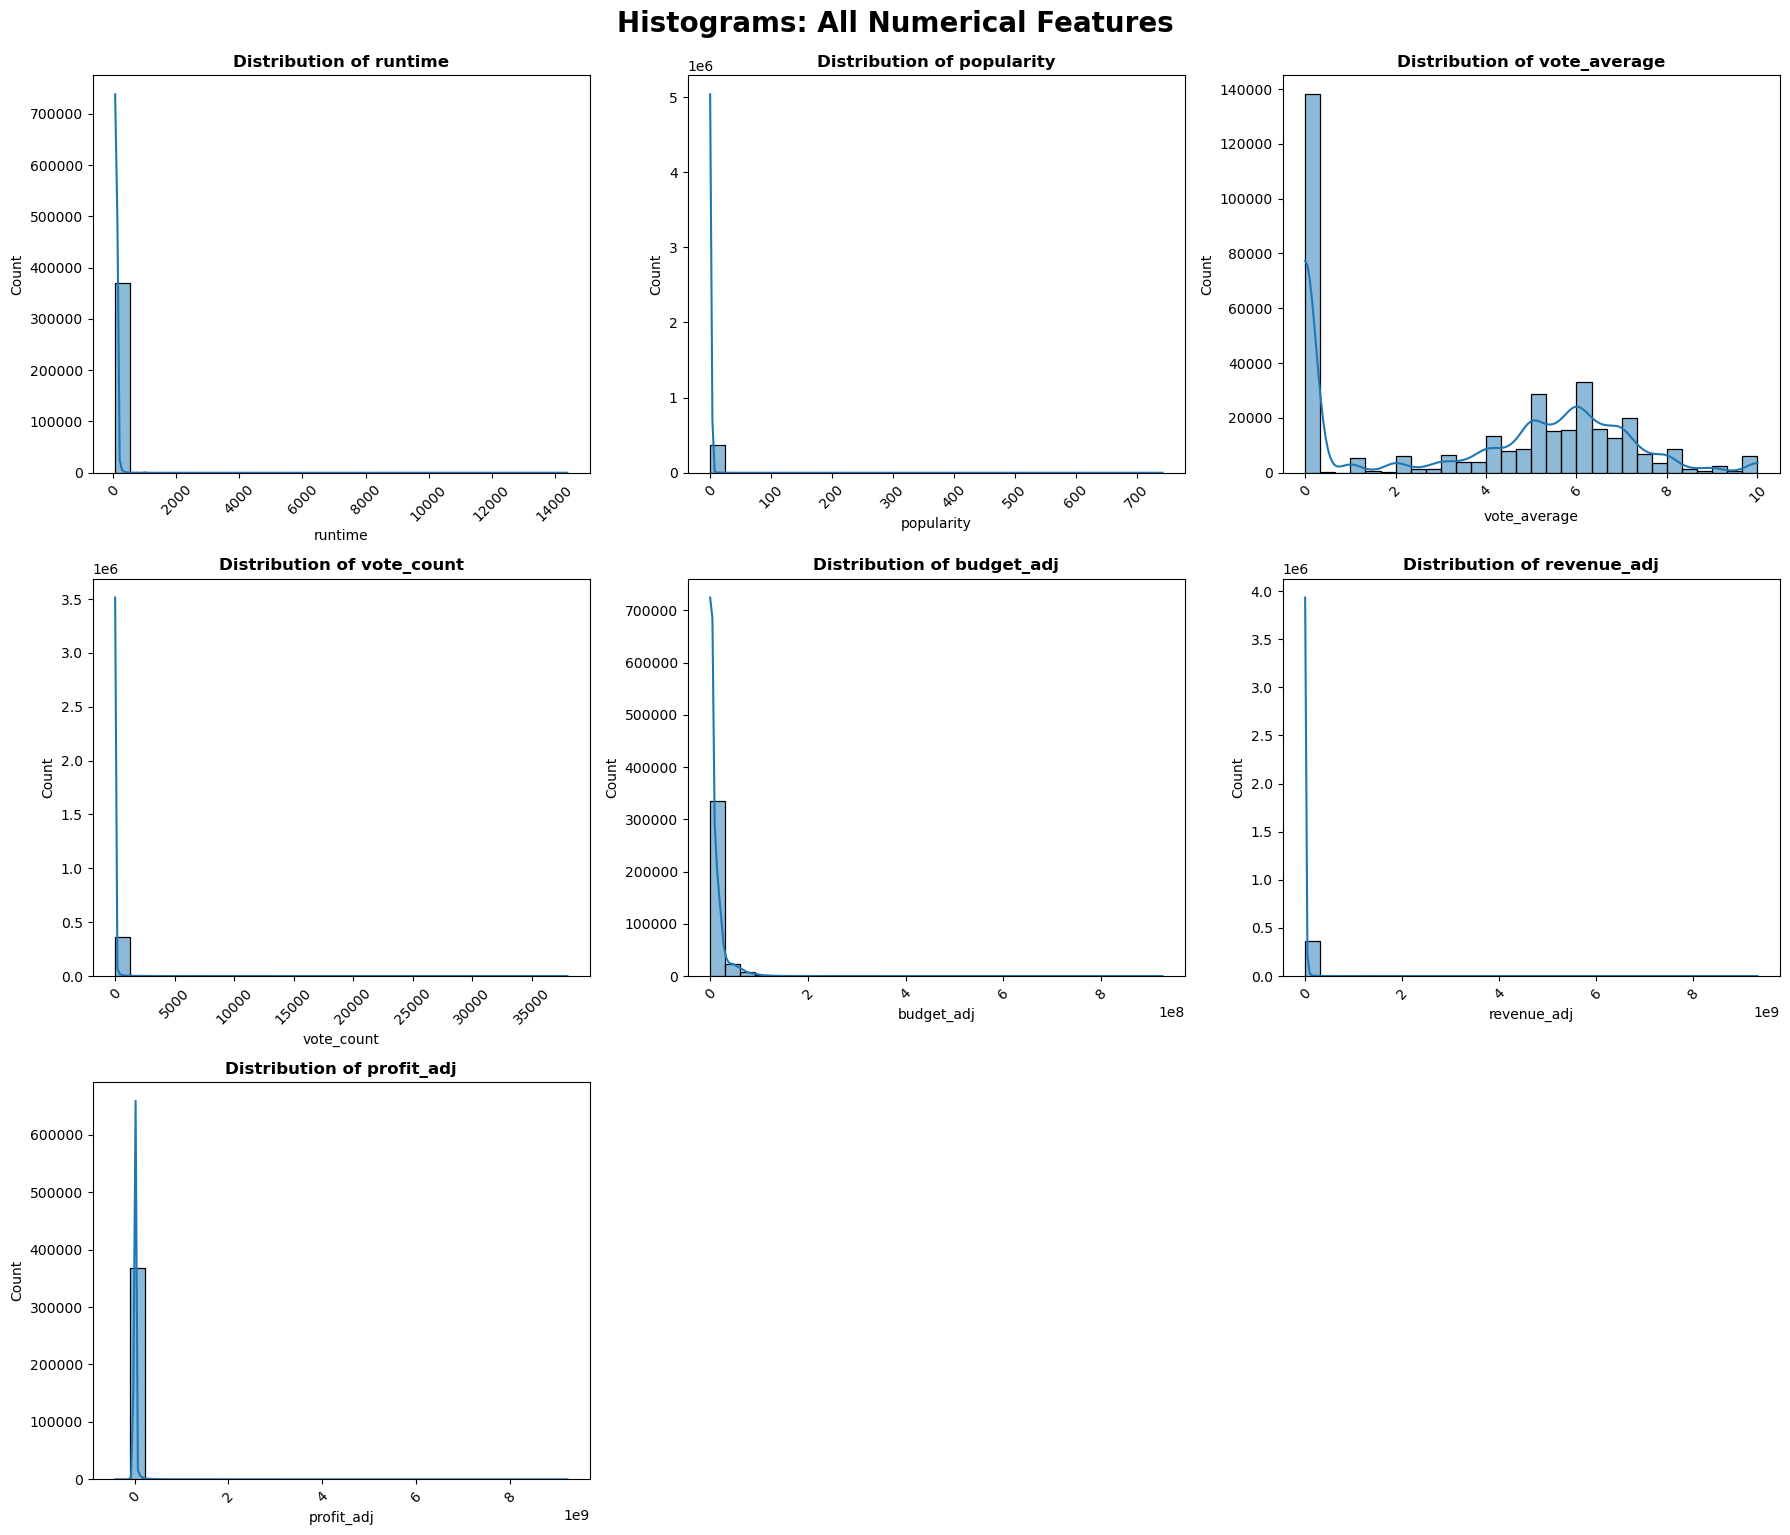

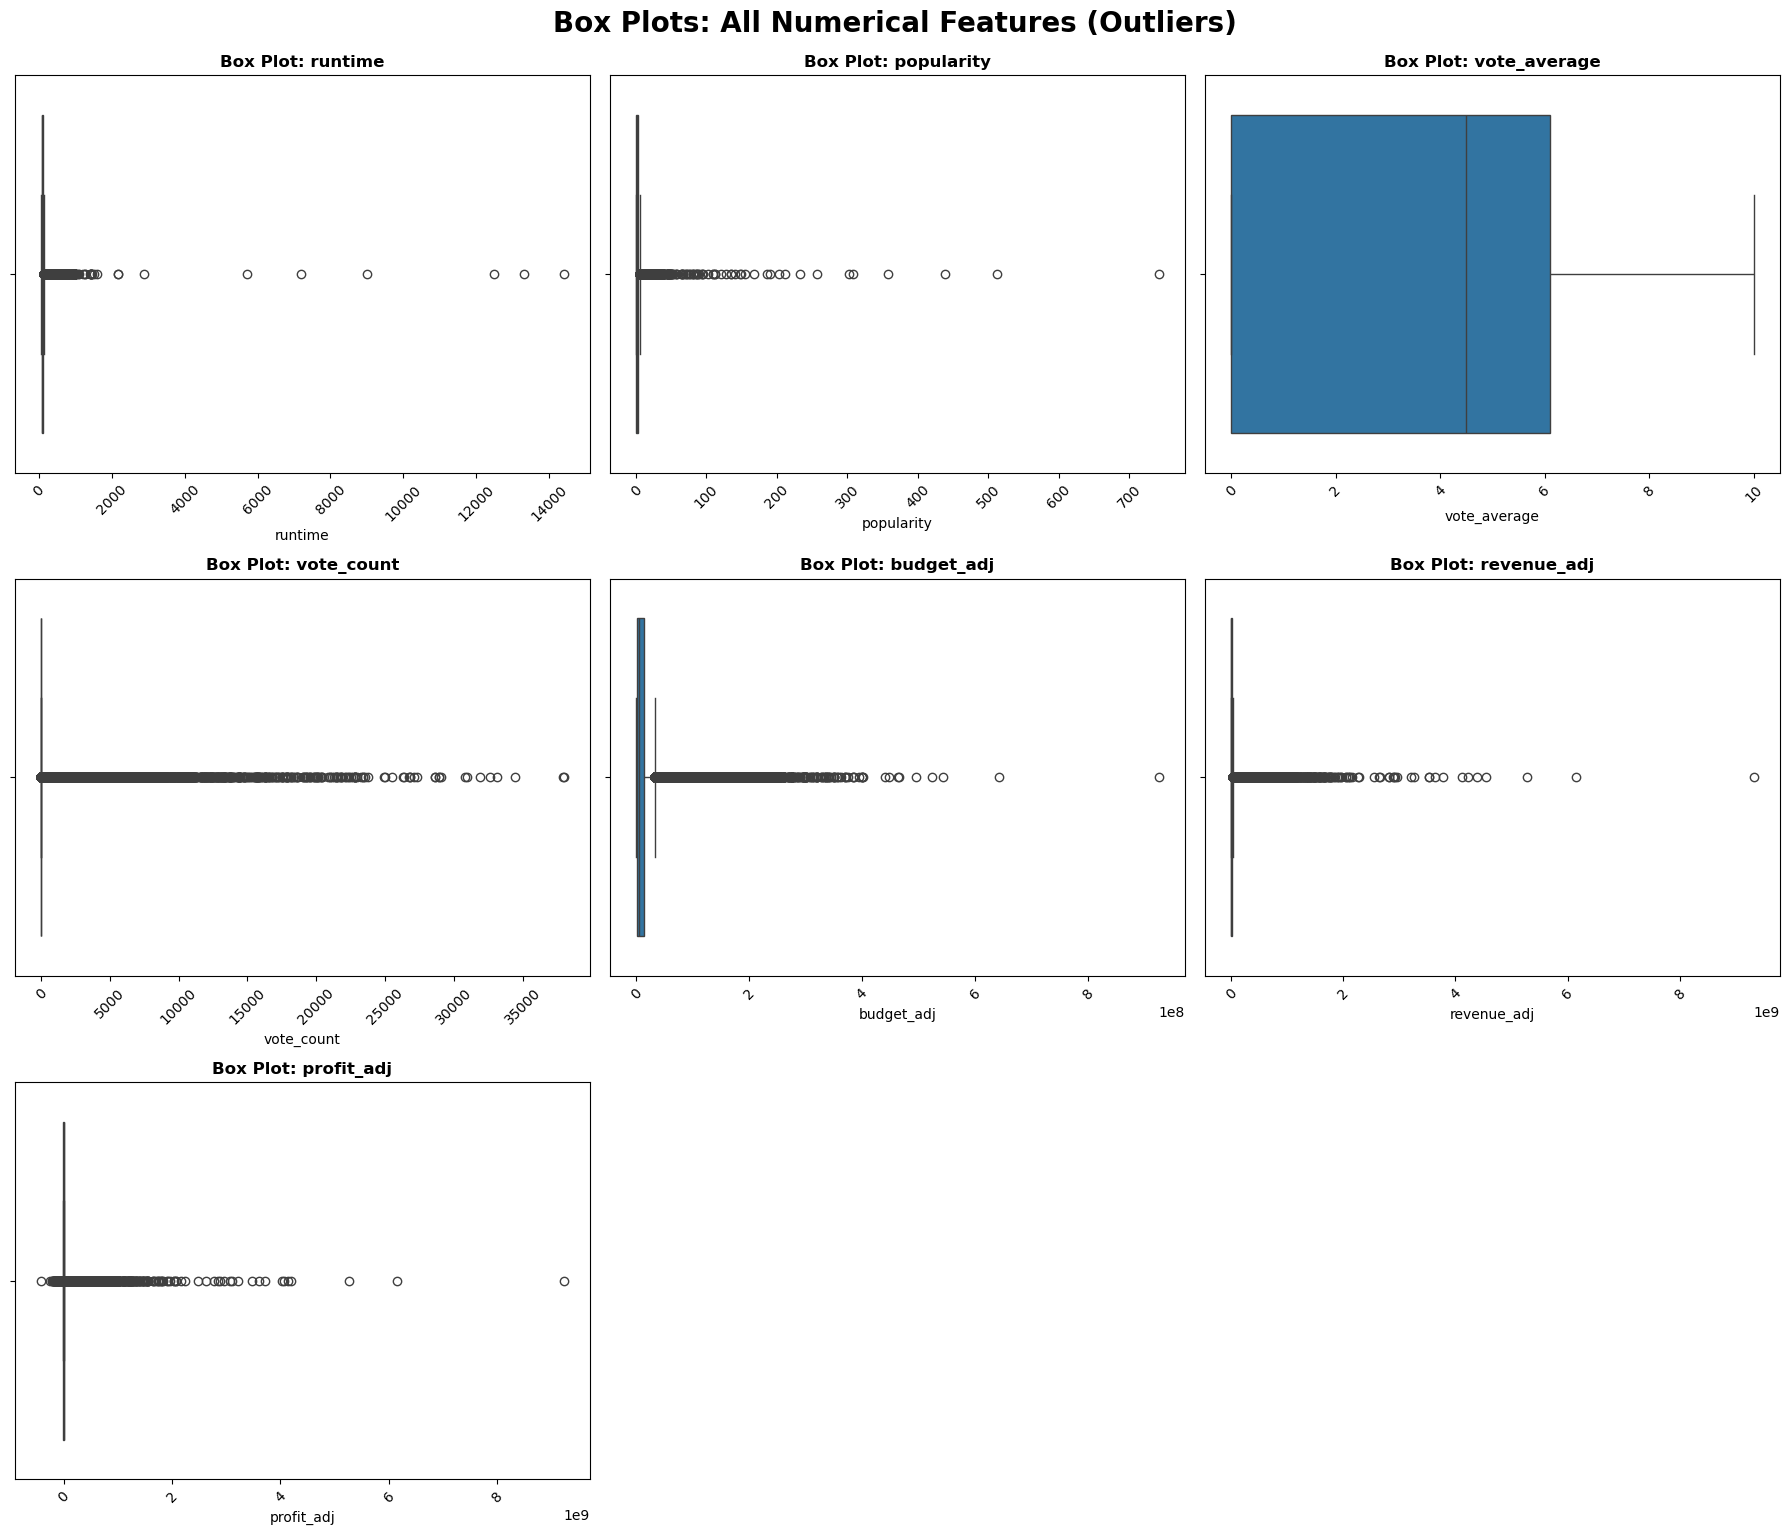

In [5]:
# Univariate Analysis

# define a list of key features
numerical_features = [
    'runtime', 'popularity', 'vote_average', 'vote_count',
    'budget_adj', 'revenue_adj', 'profit_adj'
]

# Only include columns that exist and have data
available_num = [col for col in numerical_features if col in df.columns]

df_num = df[available_num].copy()
display(Markdown(f"Analyzing {len(available_num)} numerical features"))

# Summary Statistics
display(Markdown("**Summary Statistics:**"))
summary_stats = df_num.describe().round(2).T
display(summary_stats)

# Histograms (display 3 per row)
n_cols = 3
n_rows_hist = (len(available_num) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows_hist, n_cols, figsize=(18, 5 * n_rows_hist))
if n_rows_hist == 1:
    axes = axes.ravel()
else:
    axes = axes.ravel()

for i, feature in enumerate(available_num):
    # Iterates through each numerical feature in the dataset.
    
    sns.histplot(df_num[feature].dropna(), kde=True, bins=30, ax=axes[i])
    # Creates a histogram for the current numerical feature:
    # - `df_num[feature]`: Selects the feature data.
    # - `kde=True`: Adds a Kernel Density Estimate (smooth curve) over the histogram.
    # - `bins=30`: Sets the number of bins to 30 for better granularity.
    
    axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
    # Sets the title of the histogram using the feature name.
    
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for i in range(len(available_num), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Histograms: All Numerical Features', fontweight='bold', fontsize=20, y=1.02)
plt.show()


# Boxplots to detect outliers (display 3 per row)
fig, axes = plt.subplots(n_rows_hist, n_cols, figsize=(18, 5 * n_rows_hist))
if n_rows_hist == 1:
    axes = axes.ravel()
else:
    axes = axes.ravel()

for i, feature in enumerate(available_num):
    # Iterates through each numerical feature in the dataset.
    
    sns.boxplot(data=df_num, x=feature, ax=axes[i])
    # Creates a box plot to visualize the distribution and detect potential outliers:
    # - Boxplots show the median, quartiles, and potential outliers as individual points.
    
    axes[i].set_title(f'Box Plot: {feature}', fontweight='bold')
    # Sets the title of the box plot using the feature name.
    
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
for i in range(len(available_num), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Box Plots: All Numerical Features (Outliers)', fontweight='bold', fontsize=20, y=1.02)
plt.show()

<hr />
<h2>Bivariate/Multivariate Analysis</h2>
<p>Bivariate analysis is the simultaneous analysis of two variables. Multivariate analysis is an extension of bivariate analysis which means it involves multiple variables at the same time to find correlation between them.  - <a href="https://www.geeksforgeeks.org/data-visualization/what-is-univariate-bivariate-multivariate-analysis-in-data-visualisation/" target=_blank>GeeksforGeeks</a></p>
<hr />

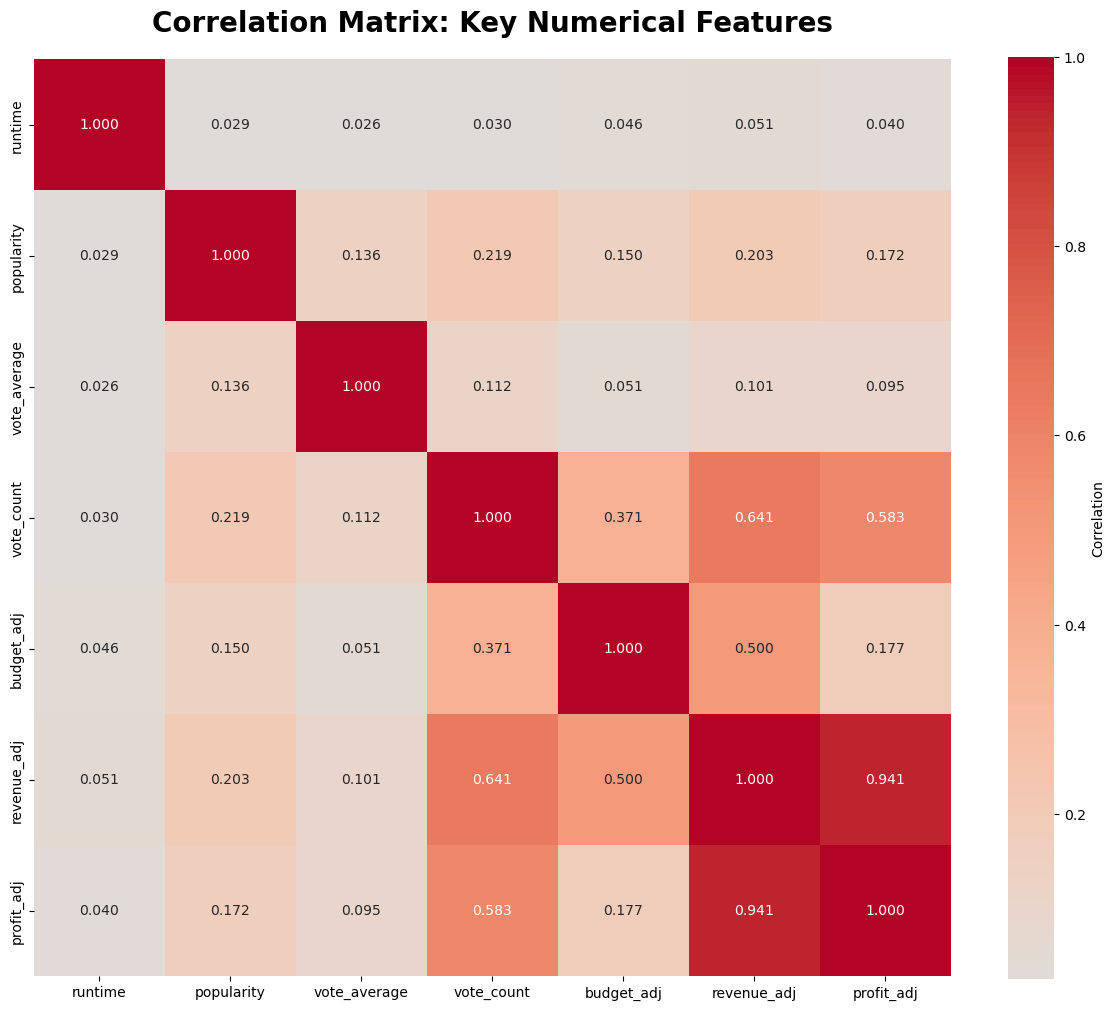

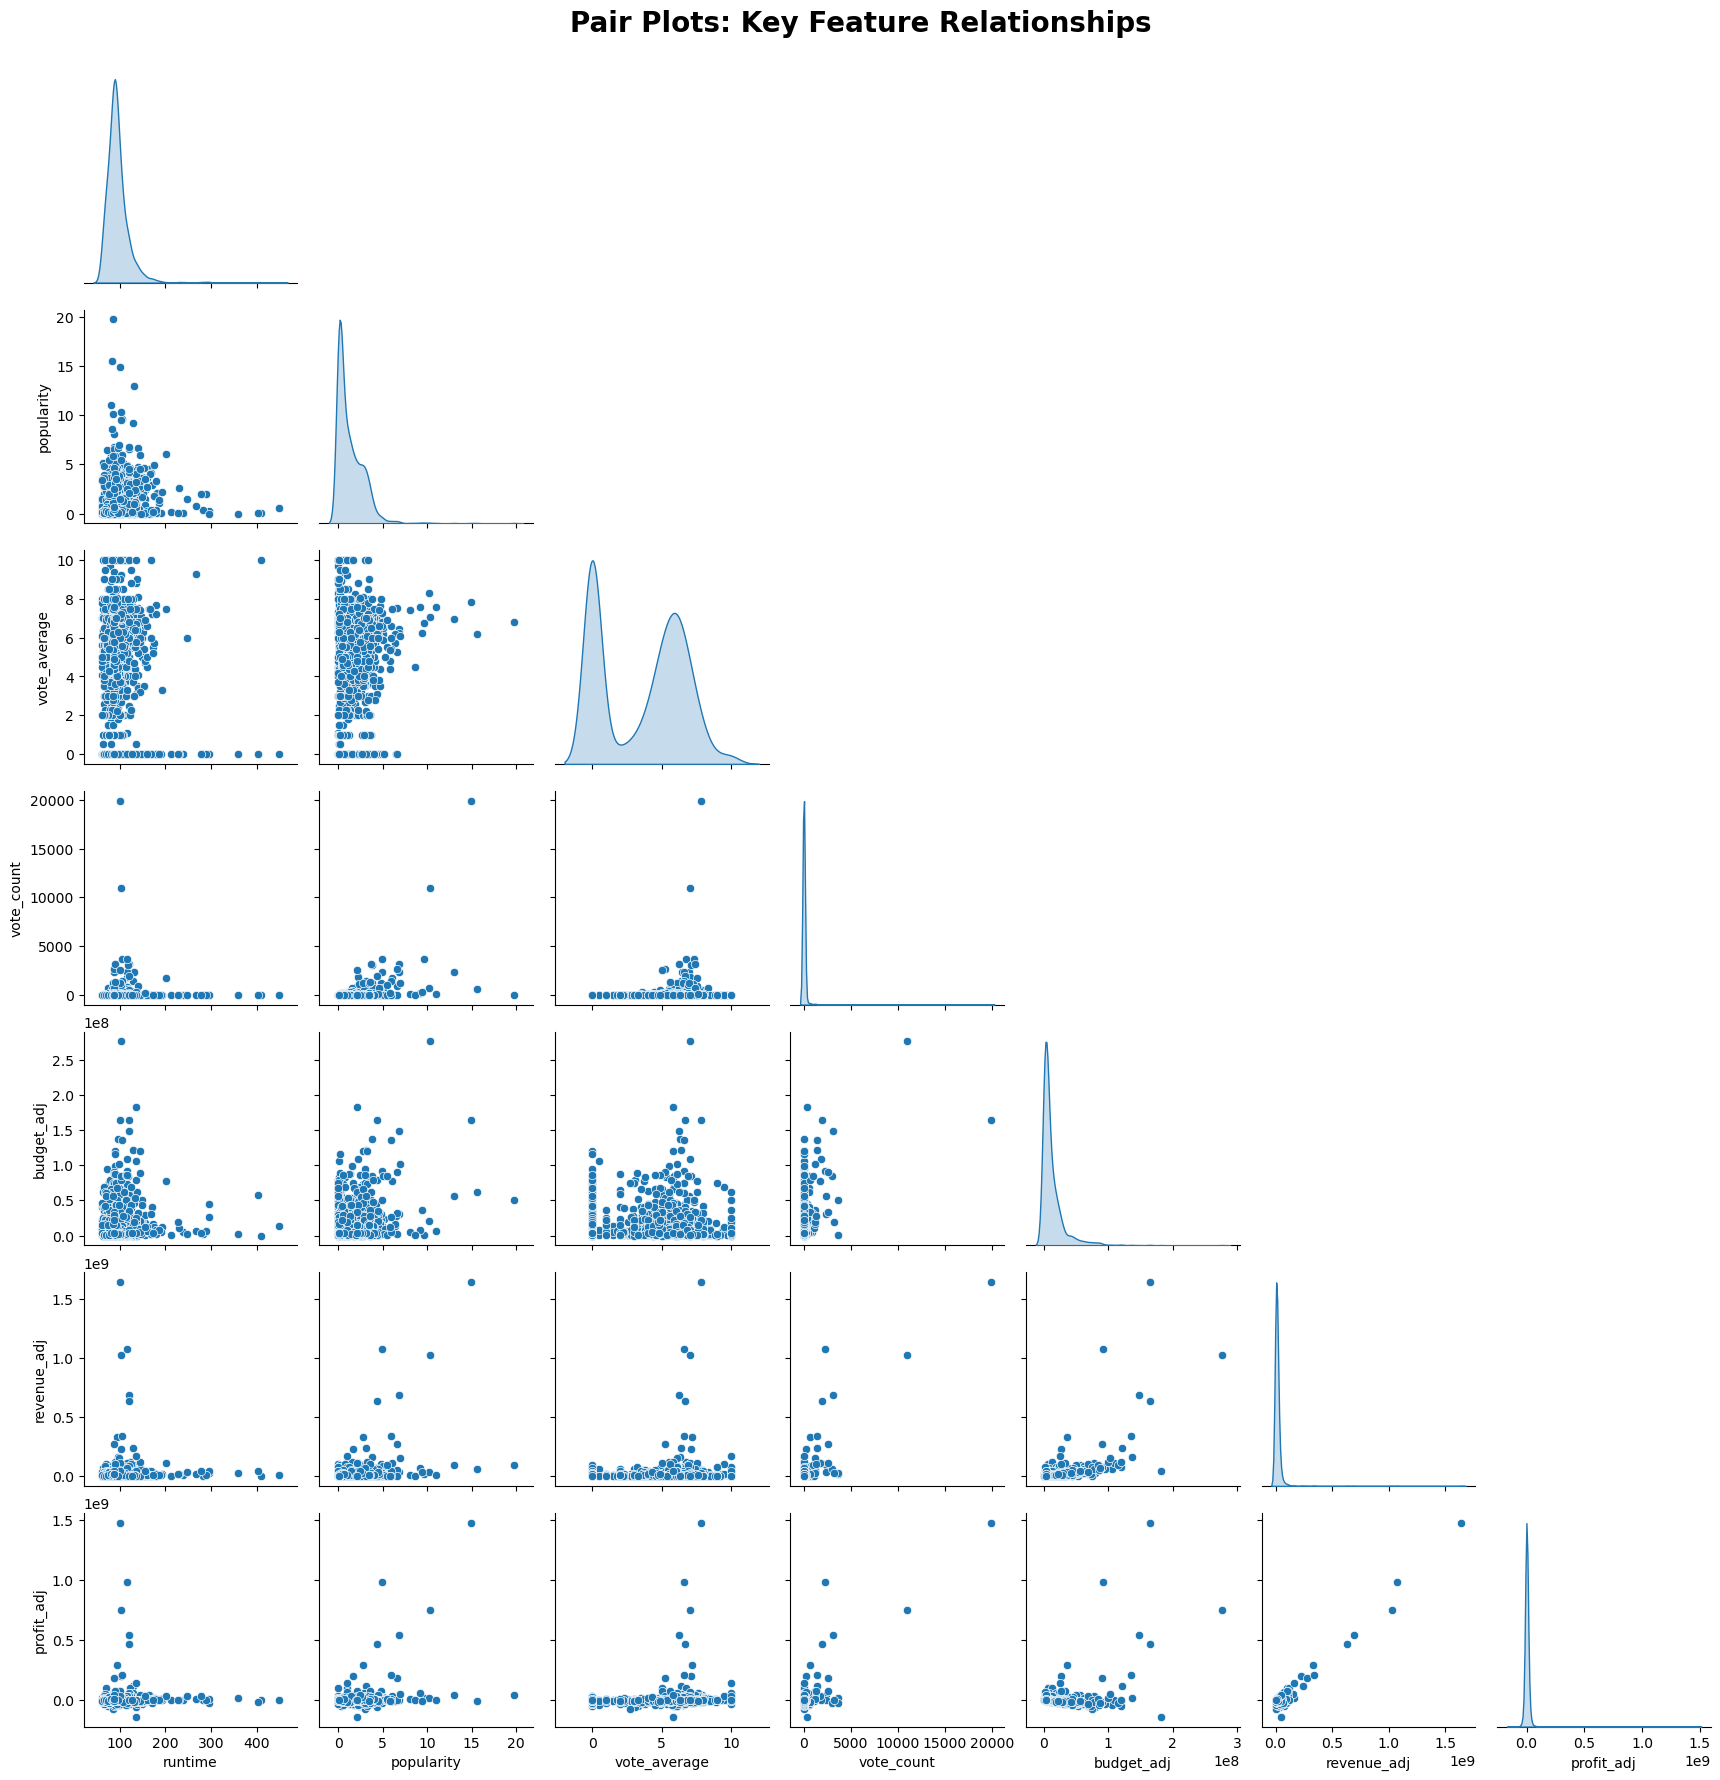

In [6]:
# Bivariate/Multivariate Analysis

# use same key features from code block above

# Correlation Matrix and Heatmap
# Computes the correlation matrix for the selected features
corr_matrix = df_num.corr().round(3)

plt.figure(figsize=(12, 10))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, 
            annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f',
            cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: Key Numerical Features', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Pairplots
# Creates a pairplot for the selected features
# The pairplot provides scatter plots for each pair of numerical variables, 
# helping to identify trends, correlations, and potential nonlinear relationships.
sns.pairplot(df_num[available_num].sample(min(2000, len(df_num))), 
             diag_kind='kde', corner=True)
plt.suptitle('Pair Plots: Key Feature Relationships', fontsize=20, fontweight='bold', y=1.02)
plt.show()

<h3>Remove Extreme Outliers</h3>
<span style="font-size: 1.1em;">
<ul>
    <li>Remove movies with runtimes greater than 250 minutes.</li>
    <li>Limit revenue to \$5 billion.<br />
        The highest grossing film of all time is <span style="font-style: italic;">Avatar</span> (2009) at \$2.9 billion; when adjusted for inflation, that claim goes to <span style="font-style: italic;">Gone With The Wind</span> (1939) at \$4.5 billion</li>
    <li>Even adjusted for inflation, very few movies exceed a \$350–400 million budget.<br />
        <span style="font-style: italic;">Star Wars: The Force Awakens</span> (2015) holds the record with a \$447 million budget. A \$925 million budget could be a data entry error.</li>
    <li>Apply log transformations to other columns to shrink the massive gap between extreme outliers and the rest of the data.</li>
</ul>
</span>
<br />
<p>Guiness World Records. (2026, February 14). <span style="font-style: italic;">Highest-grossing film at the global box office (inflation-adjusted)</span>. <a href="https://www.guinnessworldrecords.com/world-records/highest-box-office-film-gross-inflation-adjusted" target=_blank>https://www.guinnessworldrecords.com/world-records/highest-box-office-film-gross-inflation-adjusted</a></p>
<p>Sheppard, C. (2024, January 5). <span style="font-style: italic;">The 12 most expensive movies ever made</span>. IGN. <a href="https://www.ign.com/articles/most-expensive-movies" target=_blank>https://www.ign.com/articles/most-expensive-movies</a></p>

In [7]:
# Remove extreme outliers
df_cleaned = df[
    (df['runtime'] <= 250) & 
    (df['revenue_adj'] <= 4000000000)
].copy()

# Log transform columns in cleaned dataframe
columns_to_log = ['popularity', 'vote_count', 'budget_adj', 'revenue_adj']
for col in columns_to_log:
    df_cleaned[f'log_{col}'] = np.log1p(df_cleaned[col])

# recalculate profit for consistency
df_cleaned['profit_adj'] = df_cleaned['revenue_adj'] - df_cleaned['budget_adj']

# print results
display(Markdown(f"**Original rows:** {len(df)}"))
display(Markdown(f"**Cleaned rows:** {len(df_cleaned)}"))
display(Markdown(f"**Rows removed:** {len(df) - len(df_cleaned)}"))
display(Markdown(f"**New Columns:** {[c for c in df_cleaned.columns if 'log_' in c]}"))

**Original rows:** 370118

**Cleaned rows:** 368553

**Rows removed:** 1565

**New Columns:** ['log_popularity', 'log_vote_count', 'log_budget_adj', 'log_revenue_adj']

<hr />
<h2>Design and Implement Neural Networks</h2>
<p>Neural networks are machine learning models that mimic the complex functions of the human brain. These models consist of interconnected nodes or neurons that process data, learn patterns, and enable tasks such as pattern recognition and decision-making. - <a href="https://www.geeksforgeeks.org/deep-learning/neural-networks-a-beginners-guide/" target=_blank>GeeksforGeeks</a></p>
<hr />

<h3>Q1: Predicting Film ROI from Inflation-Adjusted Budget</h3>

<p>Once we adjust for inflation, do small indie films, mid-sized movies, or massive blockbusters make the most profit relative to their cost? Is there a limit to how much money a studio should spend?</p>

<p><strong>Goal:</strong> Develop a supervised model that predicts a film’s ROI from its inflation-adjusted budget and other controls, and use it to estimate expected ROI for each budget tier.</p>

<p><strong>Approach:</strong> Two complementary supervised models are trained:
<ol>
  <li><strong>Classification</strong> — Predicts which ROI tier a film falls into (Low / Mid / High), using Logistic Regression (baseline) and Gradient Boosting Classifier.</li>
  <li><strong>Regression</strong> — Predicts continuous ROI using a Gradient Boosting Regressor, then aggregates expected ROI per budget tier.</li>
</ol>
</p>

<p>Both models use inflation-adjusted budget as the primary predictor alongside runtime, popularity, vote signals, and release year as controls.</p>

<p><strong>Features used as predictors:</strong>
<ul>
  <li><strong>log_budget_adj</strong> — primary predictor of interest (log inflation-adjusted budget)</li>
  <li><strong>log_popularity, log_vote_count, vote_average</strong> — audience engagement controls</li>
  <li><strong>runtime</strong> — production scope control</li>
  <li><strong>release_year</strong> — temporal control (industry trends, era effects)</li>
</ul>
</p>
    
<p>A 70/15/15 stratified train/validation/test split is used throughout.</p>

In [8]:
### Q1 FEATURE ENGINEERING ###

# Filter to films with valid budget AND revenue
q1_df = df_cleaned[
    (df_cleaned['budget_adj'] > 0) &
    (df_cleaned['revenue_adj'] > 0) &
    df_cleaned['budget_adj'].notna() &
    df_cleaned['revenue_adj'].notna()
].copy()

display(Markdown(f"**Q1 dataset:** {len(q1_df):,} films"))
display(Markdown(f"**Rows excluded (missing budget/revenue):** {len(df_cleaned) - len(q1_df):,}"))

**Q1 dataset:** 368,553 films

**Rows excluded (missing budget/revenue):** 0

In [9]:
### Q1 ###
# Compute ROI and winsorize at 1st / 99th percentile
# ROI = (Revenue - Budget) / Budget
#
# Winsorizing replaces extreme outliers with the 1st/99th percentile value
# rather than deleting them, preserving sample size while limiting distortion.

q1_df['roi'] = q1_df['profit_adj'] / q1_df['budget_adj']
q1_df['roi'] = np.array(winsorize(q1_df['roi'], limits=[0.01, 0.01]))

display(Markdown("**ROI descriptive statistics (after winsorizing):**"))
display(q1_df['roi'].describe().round(3).to_frame().T)

**ROI descriptive statistics (after winsorizing):**

,count,mean,std,min,25%,50%,75%,max
roi,368553.0,1.524,3.341,-0.953,-0.311,0.132,1.998,16.419


In [10]:
### Q1 ###
# ROI Tiers
#
# Divide ROI into three equal-sized quantile bins so every class has the same
# number of observations — this avoids class-imbalance issues.

q1_df['roi_tier'], roi_bins = pd.qcut(
    q1_df['roi'], q=3,
    labels=['Low ROI', 'Mid ROI', 'High ROI'],
    retbins=True
)

display(Markdown("**ROI tier boundaries:**"))
display(Markdown(f"Low ROI: ROI ≤ {roi_bins[1]:.3f}"))
display(Markdown(f"Mid ROI: {roi_bins[1]:.3f} < ROI ≤ {roi_bins[2]:.3f}"))
display(Markdown(f"High ROI: ROI > {roi_bins[2]:.3f}"))
display(Markdown("\n**Class distribution:**"))
display(q1_df['roi_tier'].value_counts().reindex(['Low ROI', 'Mid ROI', 'High ROI']).to_frame())

**ROI tier boundaries:**

Low ROI: ROI ≤ -0.213

Mid ROI: -0.213 < ROI ≤ 1.073

High ROI: ROI > 1.073


**Class distribution:**

,count
roi_tier,
Low ROI,122851
Mid ROI,122851
High ROI,122851


In [11]:
### Q1 ###
# Budget Tiers
#
# Three tiers split at the 33rd / 67th percentile of log-adjusted budget:
#   Indie — lowest third of spending
#   Mid — middle third
#   Blockbuster — top third

low_thresh  = q1_df['log_budget_adj'].quantile(0.33)
high_thresh = q1_df['log_budget_adj'].quantile(0.67)

def assign_budget_tier(log_b):
    if log_b <= low_thresh:
        return 'Indie'
    elif log_b <= high_thresh:
        return 'Mid'
    else:
        return 'Blockbuster'

q1_df['budget_tier'] = q1_df['log_budget_adj'].apply(assign_budget_tier)

# Display actual dollar ranges per tier
tier_ranges = q1_df.groupby('budget_tier')['budget_adj'].agg(['min','max','median']) / 1e6
tier_ranges.columns = ['Min Budget ($M)', 'Max Budget ($M)', 'Median Budget ($M)']
display(Markdown("**Budget tier dollar ranges:**"))
display(tier_ranges.reindex(['Indie','Mid','Blockbuster']).round(1))

**Budget tier dollar ranges:**

,Min Budget ($M),Max Budget ($M),Median Budget ($M)
budget_tier,,,
Indie,0.0,2.6,1.2
Mid,2.6,10.6,5.0
Blockbuster,10.6,642.2,20.6


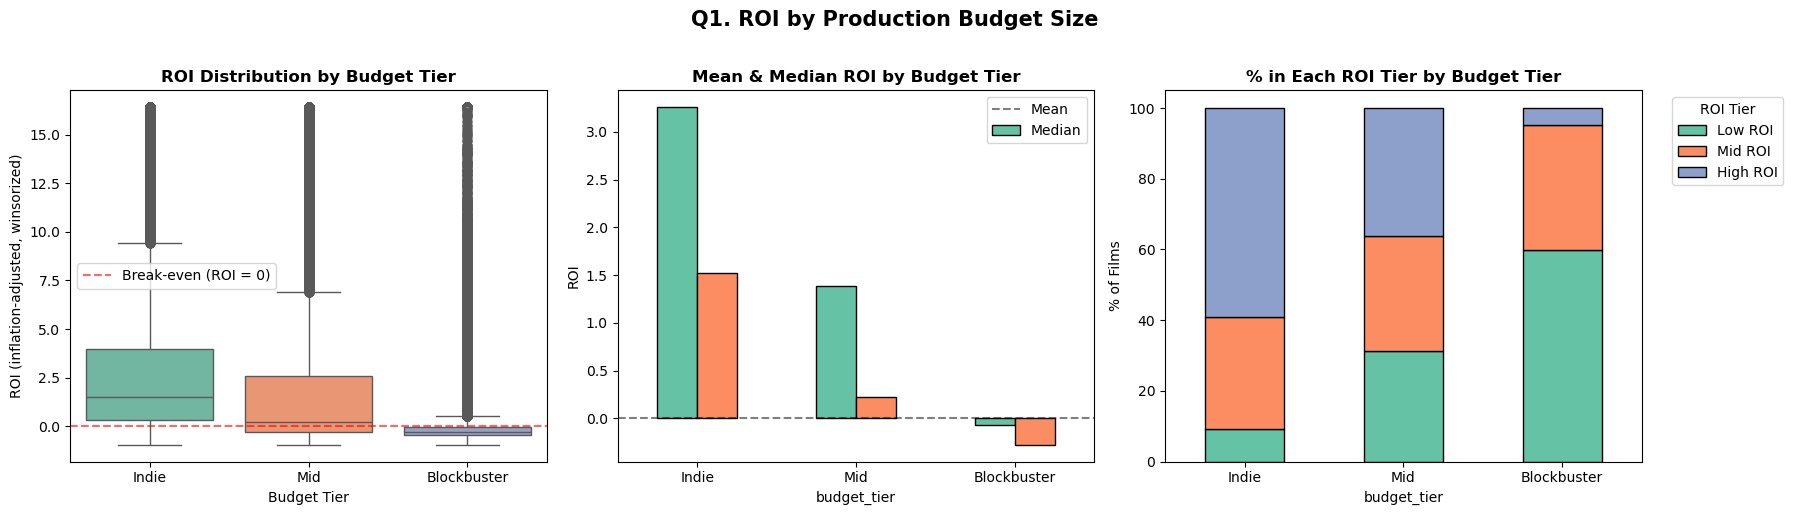

In [12]:
### Q1 VISUALIZATIONS ###

tier_order = ['Indie', 'Mid', 'Blockbuster']
roi_order  = ['Low ROI', 'Mid ROI', 'High ROI']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROI distribution (box plot)
sns.boxplot(
    data=q1_df, x='budget_tier', y='roi',
    order=tier_order, palette=PALETTE, ax=axes[0]
)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even (ROI = 0)')
axes[0].set_title('ROI Distribution by Budget Tier', fontweight='bold')
axes[0].set_xlabel('Budget Tier')
axes[0].set_ylabel('ROI (inflation-adjusted, winsorized)')
axes[0].legend()

# Mean & Median ROI
roi_stats = (
    q1_df.groupby('budget_tier')['roi']
    .agg(['mean', 'median'])
    .reindex(tier_order)
)
roi_stats.plot(kind='bar', ax=axes[1], color=PALETTE, edgecolor='black')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Mean & Median ROI by Budget Tier', fontweight='bold')
axes[1].set_ylabel('ROI')
axes[1].set_xticklabels(tier_order, rotation=0)
axes[1].legend(['Mean', 'Median'])

# Stacked proportion of ROI tiers
cross = pd.crosstab(q1_df['budget_tier'], q1_df['roi_tier'], normalize='index') * 100
cross.reindex(tier_order)[roi_order].plot(
    kind='bar', stacked=True, ax=axes[2],
    color=PALETTE, edgecolor='black'
)
axes[2].set_title('% in Each ROI Tier by Budget Tier', fontweight='bold')
axes[2].set_ylabel('% of Films')
axes[2].set_xticklabels(tier_order, rotation=0)
axes[2].legend(title='ROI Tier', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Q1. ROI by Production Budget Size',
             fontweight='bold', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
### Q1 FEATURE SELECTION ###
# and train/val/test split #

FEATURE_COLS = [
    'log_budget_adj',
    'log_popularity',
    'log_vote_count',
    'vote_average', 
    'runtime',
    'release_year', 
]
FEATURE_COLS = [c for c in FEATURE_COLS if c in q1_df.columns]

model_df = q1_df[FEATURE_COLS + ['roi_tier', 'roi', 'budget_tier', 'budget_adj', 'id']].dropna()

display(Markdown(f"**Modeling dataset:** {model_df.shape[0]:,} rows × {len(FEATURE_COLS)} features"))
display(Markdown(f"**Features:** {FEATURE_COLS}"))

# Encode classification target
le = LabelEncoder()
y_clf = le.fit_transform(model_df['roi_tier'])

# Regression target (continuous ROI)
y_reg = model_df['roi'].values

X = model_df[FEATURE_COLS].values

print("Class encoding:", dict(zip(le.classes_, range(len(le.classes_)))))

# 70 / 15 / 15 stratified split
X_train, X_temp, y_train, y_temp, y_reg_train, y_reg_temp = train_test_split(
    X, y_clf, y_reg, test_size=0.30, stratify=y_clf, random_state=SEED
)
X_val, X_test, y_val, y_test, y_reg_val, y_reg_test = train_test_split(
    X_temp, y_temp, y_reg_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]:,}  |  Val: {X_val.shape[0]:,}  |  Test: {X_test.shape[0]:,}")

**Modeling dataset:** 368,553 rows × 6 features

**Features:** ['log_budget_adj', 'log_popularity', 'log_vote_count', 'vote_average', 'runtime', 'release_year']

Class encoding: {'High ROI': 0, 'Low ROI': 1, 'Mid ROI': 2}
Train: 257,987  |  Val: 55,283  |  Test: 55,283


In [14]:
### Q1 BASELINE MODEL ###
# Logistic Regression #

lr = LogisticRegression(max_iter=1000, random_state=SEED, C=1.0)
lr.fit(X_train_sc, y_train)

y_pred_lr = lr.predict(X_test_sc)
y_prob_lr = lr.predict_proba(X_test_sc)

auc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='weighted')

display(Markdown("**Q1. Logistic Regression — Classification Report:**"))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
display(Markdown(f"**Weighted OvR AUC: {auc_lr:.4f}**"))

# Coefficient table
coef_df = pd.DataFrame(
    lr.coef_,
    index=le.classes_,
    columns=FEATURE_COLS
).T
display(Markdown("\n**LR Coefficients (each column = log-odds for that class):**"))
display(coef_df.round(4))

**Q1. Logistic Regression — Classification Report:**

              precision    recall  f1-score   support

    High ROI       0.74      0.73      0.73     18428
     Low ROI       0.61      0.64      0.62     18427
     Mid ROI       0.49      0.47      0.48     18428

    accuracy                           0.61     55283
   macro avg       0.61      0.61      0.61     55283
weighted avg       0.61      0.61      0.61     55283



**Weighted OvR AUC: 0.7710**


**LR Coefficients (each column = log-odds for that class):**

,High ROI,Low ROI,Mid ROI
log_budget_adj,-0.6536,0.7322,-0.0786
log_popularity,0.0149,-0.0830,0.0680
log_vote_count,0.0118,0.0102,-0.0220
vote_average,0.0310,-0.3165,0.2855
runtime,0.1097,-0.2003,0.0906
release_year,-0.4722,0.2597,0.2125


In [15]:
### Q1 ###
# Gradient Boosting Classifier #

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    random_state=SEED
)
gb_clf.fit(X_train_sc, y_train)

y_pred_gb = gb_clf.predict(X_test_sc)
y_prob_gb = gb_clf.predict_proba(X_test_sc)

auc_gb = roc_auc_score(y_test, y_prob_gb, multi_class='ovr', average='weighted')

display(Markdown("**Q1. Gradient Boosting Classifier - Classification Report:**"))
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))
display(Markdown(f"**Weighted OvR AUC: {auc_gb:.4f}**"))

**Q1. Gradient Boosting Classifier - Classification Report:**

              precision    recall  f1-score   support

    High ROI       0.92      0.91      0.92     18428
     Low ROI       0.81      0.86      0.83     18427
     Mid ROI       0.80      0.75      0.77     18428

    accuracy                           0.84     55283
   macro avg       0.84      0.84      0.84     55283
weighted avg       0.84      0.84      0.84     55283



**Weighted OvR AUC: 0.9419**

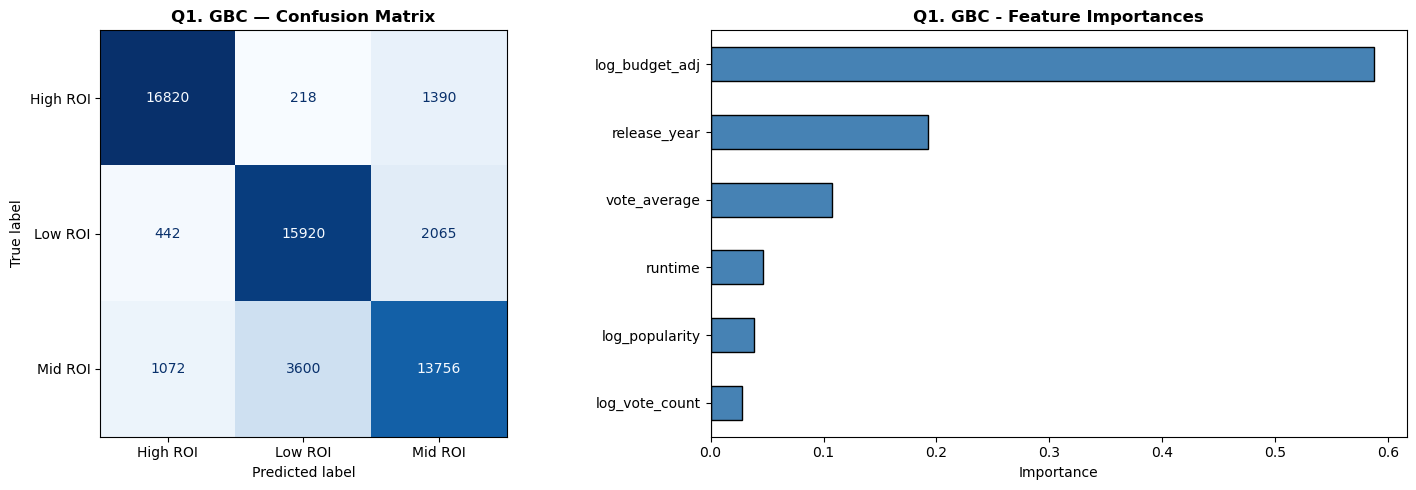

**Feature Importances (descending):**

log_budget_adj    0.5872
release_year      0.1925
vote_average      0.1079
runtime           0.0465
log_popularity    0.0384
log_vote_count    0.0276


In [16]:
### Q1 ###
# Confusion matrix + feature importances #

fi_series = pd.Series(gb_clf.feature_importances_, index=FEATURE_COLS).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_gb),
    display_labels=le.classes_
).plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Q1. GBC — Confusion Matrix', fontweight='bold')

# Feature importances
fi_series.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Q1. GBC - Feature Importances', fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

display(Markdown("**Feature Importances (descending):**"))
print(fi_series.sort_values(ascending=False).round(4).to_string())

In [ ]:
### Q1 ###
# Gradient Boosting Regressor #

gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=SEED
)
gb_reg.fit(X_train_sc, y_reg_train)

y_pred_reg = gb_reg.predict(X_test_sc)

mae  = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2   = r2_score(y_reg_test, y_pred_reg)

display(Markdown("**Q1. GBM Regressor - Test Set Performance:**"))
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Value': [round(mae, 4), round(rmse, 4), round(r2, 4)]
})
display(metrics_df)

In [ ]:
### Q1 ###
# Regression diagnostics #

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_reg_test, y_pred_reg, alpha=0.15, s=8, color='steelblue')
min_val = min(y_reg_test.min(), y_pred_reg.min())
max_val = max(y_reg_test.max(), y_pred_reg.max())
axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=1.5, label='Perfect prediction')
axes[0].set_xlabel('Actual ROI')
axes[0].set_ylabel('Predicted ROI')
axes[0].set_title(f'Actual vs Predicted ROI  (R² = {r2:.3f})', fontweight='bold')
axes[0].legend()

# Residuals
residuals = y_reg_test - y_pred_reg
axes[1].scatter(y_pred_reg, residuals, alpha=0.15, s=8, color='darkorange')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Predicted ROI')
axes[1].set_ylabel('Residual (Actual − Predicted)')
axes[1].set_title('Residuals vs Fitted Values', fontweight='bold')

plt.suptitle('Q1. GBM Regressor — Diagnostics', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
### Q1 MODEL COMPARISON ###
# Side-by-side classification metrics #

results_clf = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'Gradient Boosting Classifier'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Weighted F1': [
        f1_score(y_test, y_pred_lr, average='weighted'),
        f1_score(y_test, y_pred_gb, average='weighted')
    ],
    'Weighted AUC (OvR)': [auc_lr, auc_gb]
}).set_index('Model').round(4)

display(Markdown("**Q1. Classification Model Comparison:**"))
display(results_clf)

results_clf.plot(kind='bar', figsize=(10, 5), edgecolor='black', colormap='Set2')
plt.title('Q1. Classification Model Comparison', fontweight='bold', fontsize=13)
plt.ylabel('Score')
plt.xticks(rotation=10)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
### Q1 ###
# Predict ROI for all films #
#
# apply trained regressor to entire modeling dataset so every film
# has a predicted ROI, then group by budget tier.

model_df = model_df.copy()
X_all_sc = scaler.transform(model_df[FEATURE_COLS].values)
model_df['predicted_roi'] = gb_reg.predict(X_all_sc)

# Actual vs expected ROI summary by budget tier #
tier_summary = model_df.groupby('budget_tier').agg(
    n_films = ('roi', 'size'),
    mean_actual_roi = ('roi', 'mean'),
    median_actual = ('roi', 'median'),
    mean_pred_roi = ('predicted_roi', 'mean'),
    pct_profitable = ('roi', lambda x: (x > 0).mean() * 100),
    mean_budget_m = ('budget_adj', lambda x: x.mean() / 1e6)
).reindex(['Indie', 'Mid', 'Blockbuster']).round(3)

tier_summary.columns = [
    '# Films', 'Mean Actual ROI', 'Median Actual ROI',
    'Mean Predicted ROI', '% Profitable', 'Mean Budget ($M)'
]

display(Markdown("**Q1. Expected ROI by Budget Tier (Actual vs Model Predicted):**"))
display(tier_summary)

model_df = model_df.copy()

In [ ]:
# added to store predicted_roi in dataframe for later csv export
model_df.info()

In [ ]:
### Q1 VISUALIZATIONS ###
# expected ROI by budget tier #

tier_order = ['Indie', 'Mid', 'Blockbuster']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean Actual vs Mean Predicted ROI
x_pos = np.arange(len(tier_order))
width = 0.35
axes[0].bar(x_pos - width/2,
            tier_summary.reindex(tier_order)['Mean Actual ROI'],
            width=width, label='Actual', color='PALETTE', edgecolor='black')
axes[0].bar(x_pos + width/2,
            tier_summary.reindex(tier_order)['Mean Predicted ROI'],
            width=width, label='Predicted', color='darkorange', edgecolor='black')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.6)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(tier_order)
axes[0].set_ylabel('Mean ROI')
axes[0].set_title('Mean Actual vs Predicted ROI', fontweight='bold')
axes[0].legend()

# Median Actual ROI
tier_summary.reindex(tier_order)['Median Actual ROI'].plot(
    kind='bar', ax=axes[1], color=PALETTE, edgecolor='black'
)
axes[1].axhline(0, color='red', linestyle='--', alpha=0.6, label='Break-even')
axes[1].set_title('Median ROI by Budget Tier', fontweight='bold')
axes[1].set_ylabel('Median ROI')
axes[1].set_xticklabels(tier_order, rotation=0)
axes[1].legend()

# % Profitable
tier_summary.reindex(tier_order)['% Profitable'].plot(
    kind='bar', ax=axes[2], color=PALETTE, edgecolor='black'
)
axes[2].axhline(50, color='red', linestyle='--', alpha=0.6, label='50% line')
axes[2].set_title('% of Films Profitable by Budget Tier', fontweight='bold')
axes[2].set_ylabel('% Profitable')
axes[2].set_xticklabels(tier_order, rotation=0)
axes[2].set_ylim(0, 100)
axes[2].legend()

plt.suptitle('Q1. Expected ROI by Budget Tier — Model Predictions',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
### Q1 ###
# How does expected ROI change as budget increases? #

medians = model_df[FEATURE_COLS].median().values

budget_range = np.linspace(
    model_df['log_budget_adj'].quantile(0.01),
    model_df['log_budget_adj'].quantile(0.99),
    200
)

sweep_X = np.tile(medians, (len(budget_range), 1))
budget_idx = FEATURE_COLS.index('log_budget_adj')
sweep_X[:, budget_idx] = budget_range

sweep_X_sc = scaler.transform(sweep_X)
predicted_sweep = gb_reg.predict(sweep_X_sc)

# Convert log_budget back to dollars for the x-axis label
budget_dollars_m = (np.expm1(budget_range)) / 1e6

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(budget_dollars_m, predicted_sweep, color='steelblue', linewidth=2.5, label='Predicted ROI')
ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')

# Shade budget tier regions
indie_max_m  = np.expm1(low_thresh)  / 1e6
mid_max_m    = np.expm1(high_thresh) / 1e6

ax.axvspan(0, indie_max_m, alpha=0.10, color=PALETTE[0], label='Indie')
ax.axvspan(indie_max_m, mid_max_m, alpha=0.10, color=PALETTE[1], label='Mid')
ax.axvspan(mid_max_m, budget_dollars_m.max(), alpha=0.10, color=PALETTE[2], label='Blockbuster')

ax.set_xlabel('Inflation-Adjusted Budget (2025 $M)', fontsize=12)
ax.set_ylabel('Predicted ROI', fontsize=12)
ax.set_title('Q1. Partial Dependence of Predicted ROI on Budget\n'
             '(all other features held at median)',
             fontweight='bold', fontsize=13)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
### Q1 SUMMARY ###

best_tier_median = tier_summary['Median Actual ROI'].idxmax()
best_tier_prof = tier_summary['% Profitable'].idxmax()

display(Markdown("#### Q1. Key Findings — Budget Tier & ROI"))

display(Markdown("**Classification Model Performance:**"))
print(f"   Logistic Regression  — Accuracy: {accuracy_score(y_test, y_pred_lr):.1%}  "
      f"| F1: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}  "
      f"| AUC: {auc_lr:.4f}")
print(f"   Gradient Boosting    — Accuracy: {accuracy_score(y_test, y_pred_gb):.1%}  "
      f"| F1: {f1_score(y_test, y_pred_gb, average='weighted'):.4f}  "
      f"| AUC: {auc_gb:.4f}")
print()

display(Markdown("**Regression Model Performance (GBM Regressor):**"))
print(f"   MAE: {mae:.4f}  |  RMSE: {rmse:.4f}  |  R²: {r2:.4f}")
print()

display(Markdown("**Expected ROI by Budget Tier:**"))
for tier in ['Indie', 'Mid', 'Blockbuster']:
    row = tier_summary.loc[tier]
    print(f"   {tier:12s}  "
          f"Mean Predicted ROI: {row['Mean Predicted ROI']:+.3f}  "
          f"| Median Actual: {row['Median Actual ROI']:+.3f}  "
          f"| Profitable: {row['% Profitable']:.1f}%  "
          f"| Avg Budget: ${row['Mean Budget ($M)']:.1f}M")
print()

display(Markdown(f"**Budget 'sweet spot' (highest median ROI):** {best_tier_median}"))
display(Markdown(f"**Budget 'sweet spot' (most likely profitable):** {best_tier_prof}"))

<hr />

<h2>Q2. What Movie Attributes Drive Popularity and Ratings?</h2>

<p>How do things like a movie's genre, length, or language affect how many people watch it and how much they like it? Do big-name studios and high budgets automatically guarantee a movie will be popular?</p>

<p><strong>Approach:</strong> Two supervised regression pipelines are trained — one predicting log_popularity (audience reach) and one predicting vote_average (audience quality). Only pre-release attributes (genre flags, runtime, language, budget, studio tier) are used as features, simulating what a distributor could forecast before a film opens. Feature importances from a Gradient Boosting Regressor rank each attribute's contribution, and a Linear Regression baseline provides interpretable coefficient estimates.</p>

<p><strong>Pre-release features built from the cleaned dataset:</strong>
<ul>
  <li><strong>Genre flags</strong> — one-hot indicator for each of the top 15 genres</li>
  <li><strong>Runtime bucket</strong> — Short (&lt;90 min) / Standard (90-119) / Long (120-179) / Epic (180+)</li>
  <li><strong>Language group</strong> — top 6 languages individually; rest grouped as "other"</li>
  <li><strong>Studio tier</strong> — binary: produced by one of the top 20 companies by output</li>
  <li><strong>log_budget_adj</strong> — inflation-adjusted budget (log-scaled); 0-filled when missing</li>
  <li><strong>has_budget</strong> — flag indicating whether budget data was available</li>
  <li><strong>release_year</strong> — temporal control</li>
</ul>
</p>

In [ ]:
### Q2 FEATURE ENGINEERING ###

# Filter to films with valid budget AND revenue
q2_df = df_cleaned[
    (df_cleaned['budget_adj'] > 0) &
    (df_cleaned['revenue_adj'] > 0) &
    df_cleaned['budget_adj'].notna() &
    df_cleaned['revenue_adj'].notna()
].copy()

# Genre flags
def parse_list_col(val):
    if pd.isna(val): return []
    val = str(val).strip()
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list):
            return [str(x).strip() for x in parsed]
    except Exception:
        pass
    return re.findall(r"['\"]([^'\"]+)['\"]", val)

q2_df["genre_list"] = q2_df["genre_names"].apply(parse_list_col)
all_genres = [g for sublist in q2_df["genre_list"] for g in sublist]
top_genres = [g for g, _ in Counter(all_genres).most_common(15)]

for genre in top_genres:
    col = "genre_" + genre.lower().replace(" ", "_").replace("-", "_")
    q2_df[col] = q2_df["genre_list"].apply(lambda lst: int(genre in lst))

genre_cols2 = ["genre_" + g.lower().replace(" ", "_").replace("-", "_") for g in top_genres]

# Runtime bucket
def runtime_bucket(rt):
    if rt < 90: return "Short"
    elif rt < 120: return "Standard"
    elif rt < 180: return "Long"
    else: return "Epic"

q2_df["runtime_bucket"] = q2_df["runtime"].apply(runtime_bucket)
rt_dummies2 = pd.get_dummies(q2_df["runtime_bucket"], prefix="rt", drop_first=True)
q2_df = pd.concat([q2_df, rt_dummies2], axis=1)
runtime_cols2 = list(rt_dummies2.columns)

# Language group
top_langs2 = q2_df["original_language"].value_counts().head(6).index.tolist()
q2_df["lang_group"] = q2_df["original_language"].apply(
    lambda x: x if x in top_langs2 else "other"
)
lang_dummies2 = pd.get_dummies(q2_df["lang_group"], prefix="lang", drop_first=True)
q2_df = pd.concat([q2_df, lang_dummies2], axis=1)
lang_cols2 = list(lang_dummies2.columns)

# Studio tier
q2_df["company_list"] = q2_df["production_company_names"].apply(parse_list_col)
all_companies = [c for sublist in q2_df["company_list"] for c in sublist]
top_studios2 = {c for c, _ in Counter(all_companies).most_common(20)}
q2_df["big_studio"] = q2_df["company_list"].apply(
    lambda lst: int(any(c in top_studios2 for c in lst))
)

# Budget (zero-fill missing; flag missingness)
q2_df["has_budget"] = (q2_df["budget_adj"] > 0).astype(int)
q2_df["log_budget_adj"] = np.where(
    q2_df["budget_adj"] > 0,
    np.log1p(q2_df["budget_adj"]),
    0
)

display(Markdown(f"**Q2 top 15 genres:** {top_genres}"))
display(Markdown(f"**Q2 top languages:** {top_langs2}"))
display(Markdown(f"**Q2 dataset size:** {len(q2_df):,} films"))

In [ ]:
### Q2 VISUALIZATIONS ###

BUCKET_ORDER = ["Short", "Standard", "Long", "Epic"]

# Genre vs Popularity & Rating
genre_stats2 = {}
for genre in top_genres:
    col = "genre_" + genre.lower().replace(" ", "_").replace("-", "_")
    subset = q2_df[q2_df[col] == 1]
    genre_stats2[genre] = {
        "Median Popularity": subset["popularity"].median(),
        "Mean Rating": subset["vote_average"].mean(),
        "# Films": len(subset)
    }
genre_stats2_df = pd.DataFrame(genre_stats2).T

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

genre_stats2_df["Median Popularity"].sort_values(ascending=True).plot(
    kind="barh", ax=axes[0], color="steelblue", edgecolor="black")
axes[0].set_title("Median Popularity by Genre", fontweight="bold")
axes[0].set_xlabel("Median Popularity Score")

genre_stats2_df["Mean Rating"].sort_values(ascending=True).plot(
    kind="barh", ax=axes[1], color="#2ca02c", edgecolor="black")
axes[1].set_title("Mean Rating by Genre", fontweight="bold")
axes[1].set_xlabel("Mean Vote Average")
overall_mean = q2_df["vote_average"][q2_df["vote_average"] > 0].mean()
axes[1].axvline(overall_mean, color="red", linestyle="--", alpha=0.7, label=f"Overall mean ({overall_mean:.2f})")
axes[1].legend()

plt.suptitle("Q2. Genre Effects on Popularity & Rating", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

# Runtime, Language, Studio, Budget panels
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

rt_pop = q2_df.groupby("runtime_bucket")["popularity"].median().reindex(BUCKET_ORDER)
rt_pop.plot(kind="bar", ax=axes[0], color=PALETTE[0], edgecolor="black")
axes[0].set_title("Median Popularity by Runtime", fontweight="bold")
axes[0].set_ylabel("Median Popularity")
axes[0].set_xticklabels(BUCKET_ORDER, rotation=30)

lang_rating = q2_df[q2_df["vote_average"] > 0].groupby("lang_group")["vote_average"].mean().sort_values(ascending=False)
lang_rating.plot(kind="bar", ax=axes[1], color=PALETTE[1], edgecolor="black")
axes[1].set_title("Mean Rating by Language", fontweight="bold")
axes[1].set_ylabel("Mean Vote Average")
axes[1].set_xticklabels(lang_rating.index, rotation=30)

studio_pop = q2_df.groupby("big_studio")["popularity"].median()
axes[2].bar(["Indie/Other", "Big Studio"], studio_pop.values,
            color=["steelblue", "darkorange"], edgecolor="black")
for idx, v in enumerate(studio_pop.values):
    axes[2].text(idx, v + 0.01, f"{v:.3f}", ha="center", fontweight="bold")
axes[2].set_title("Median Popularity by Studio Tier", fontweight="bold")
axes[2].set_ylabel("Median Popularity")

x2 = q2_df["log_budget_adj"]
y2 = q2_df["popularity"]
axes[3].scatter(x2, y2, alpha=0.05, s=5, color="steelblue")
mask = x2 > 0
bins2 = pd.cut(x2[mask], bins=20)
bin_means2 = q2_df[mask].groupby(bins2, observed=True)["popularity"].mean()
bin_centers2 = [iv.mid for iv in bin_means2.index]
axes[3].plot(bin_centers2, bin_means2.values, color="red", linewidth=2, label="Bin mean")
axes[3].set_title("Budget vs Popularity", fontweight="bold")
axes[3].set_xlabel("Log Adj. Budget")
axes[3].set_ylabel("Popularity")
axes[3].legend()

plt.suptitle("Q2. Runtime, Language, Studio & Budget Effects", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
### Q2 FEATURE SELECTION & SPLITS ###

Q2_FEATURES = genre_cols2 + runtime_cols2 + lang_cols2 + [
    "big_studio",
    "log_budget_adj",
    "has_budget",
    "release_year"
]
Q2_FEATURES = [c for c in Q2_FEATURES if c in q2_df.columns]

display(Markdown(f"**Q2 feature set ({len(Q2_FEATURES)} features):** {Q2_FEATURES}"))

# Target 1: log_popularity (winsorize viral outliers at 99th pct)
pop_99 = q2_df["popularity"].quantile(0.99)
q2_df["pop_winsor"] = q2_df["popularity"].clip(upper=pop_99)
q2_df["log_pop"] = np.log1p(q2_df["pop_winsor"])

# Target 2: vote_average (exclude unrated films)
q2_rated = q2_df[q2_df["vote_average"] > 0].copy()

# Popularity modeling dataset
pop_df = q2_df[Q2_FEATURES + ["log_pop"]].dropna()
X_pop = pop_df[Q2_FEATURES].values
y_pop = pop_df["log_pop"].values

# Rating modeling dataset
rat_df = q2_rated[Q2_FEATURES + ["vote_average"]].dropna()
X_rat = rat_df[Q2_FEATURES].values
y_rat = rat_df["vote_average"].values

display(Markdown(f"**Popularity dataset:** {len(pop_df):,} films"))
display(Markdown(f"**Rating dataset (vote_average > 0):** {len(rat_df):,} films"))

# 70 / 15 / 15 splits
X_pop_tr, X_pop_tmp, y_pop_tr, y_pop_tmp = train_test_split(
    X_pop, y_pop, test_size=0.30, random_state=SEED)
X_pop_val, X_pop_te, y_pop_val, y_pop_te = train_test_split(
    X_pop_tmp, y_pop_tmp, test_size=0.50, random_state=SEED)

X_rat_tr, X_rat_tmp, y_rat_tr, y_rat_tmp = train_test_split(
    X_rat, y_rat, test_size=0.30, random_state=SEED)
X_rat_val, X_rat_te, y_rat_val, y_rat_te = train_test_split(
    X_rat_tmp, y_rat_tmp, test_size=0.50, random_state=SEED)

scaler_pop = StandardScaler()
X_pop_tr_sc  = scaler_pop.fit_transform(X_pop_tr)
X_pop_val_sc = scaler_pop.transform(X_pop_val)
X_pop_te_sc  = scaler_pop.transform(X_pop_te)

scaler_rat = StandardScaler()
X_rat_tr_sc  = scaler_rat.fit_transform(X_rat_tr)
X_rat_val_sc = scaler_rat.transform(X_rat_val)
X_rat_te_sc  = scaler_rat.transform(X_rat_te)

display(Markdown(f"**Popularity — Train:** {X_pop_tr.shape[0]:,} | **Val:** {X_pop_val.shape[0]:,} | **Test:** {X_pop_te.shape[0]:,}"))
display(Markdown(f"**Rating — Train:** {X_rat_tr.shape[0]:,} | **Val:** {X_rat_val.shape[0]:,} | **Test:** {X_rat_te.shape[0]:,}"))

In [ ]:
### Q2 BASELINE MODEL ###
# Linear Regression #

# Popularity
lr_pop = LinearRegression()
lr_pop.fit(X_pop_tr_sc, y_pop_tr)
y_pop_pred_lr = lr_pop.predict(X_pop_te_sc)
mae_pop_lr  = mean_absolute_error(y_pop_te, y_pop_pred_lr)
rmse_pop_lr = np.sqrt(mean_squared_error(y_pop_te, y_pop_pred_lr))
r2_pop_lr   = r2_score(y_pop_te, y_pop_pred_lr)

# Rating
lr_rat = LinearRegression()
lr_rat.fit(X_rat_tr_sc, y_rat_tr)
y_rat_pred_lr = lr_rat.predict(X_rat_te_sc)
mae_rat_lr  = mean_absolute_error(y_rat_te, y_rat_pred_lr)
rmse_rat_lr = np.sqrt(mean_squared_error(y_rat_te, y_rat_pred_lr))
r2_rat_lr   = r2_score(y_rat_te, y_rat_pred_lr)

lr_results = pd.DataFrame({
    "Target": ["log_popularity", "vote_average"],
    "MAE": [round(mae_pop_lr, 4), round(mae_rat_lr, 4)],
    "RMSE": [round(rmse_pop_lr, 4), round(rmse_rat_lr, 4)],
    "R2": [round(r2_pop_lr, 4), round(r2_rat_lr, 4)]
}).set_index("Target")

display(Markdown("**Q2. Linear Regression Baseline - Test Set Performance:**"))
display(lr_results)

# Coefficient plots (top/bottom 8 each)
coef_pop = pd.Series(lr_pop.coef_, index=Q2_FEATURES).sort_values()
coef_rat = pd.Series(lr_rat.coef_, index=Q2_FEATURES).sort_values()

def top_bottom(series, n=8):
    idx = list(range(n)) + list(range(-n, 0))
    return series.iloc[idx]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

tb_pop = top_bottom(coef_pop)
tb_pop.plot(kind="barh", ax=axes[0],
            color=["#d62728" if v < 0 else "steelblue" for v in tb_pop],
            edgecolor="black")
axes[0].axvline(0, color="black", linewidth=0.8)
axes[0].set_title("LR Coefficients — Popularity (log)", fontweight="bold")
axes[0].set_xlabel("Coefficient (standardised features)")

tb_rat = top_bottom(coef_rat)
tb_rat.plot(kind="barh", ax=axes[1],
            color=["#d62728" if v < 0 else "#2ca02c" for v in tb_rat],
            edgecolor="black")
axes[1].axvline(0, color="black", linewidth=0.8)
axes[1].set_title("LR Coefficients — Vote Average", fontweight="bold")
axes[1].set_xlabel("Coefficient (standardised features)")

plt.suptitle("Q2. Linear Regression — Feature Coefficients (Top & Bottom 8)", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
### Q2 ###
# Gradient Boosting Regressors #

# Popularity
gbr_pop = GradientBoostingRegressor(
    n_estimators=200, max_depth=4,
    learning_rate=0.05, subsample=0.8,
    random_state=SEED
)
gbr_pop.fit(X_pop_tr_sc, y_pop_tr)
y_pop_pred_gbr = gbr_pop.predict(X_pop_te_sc)
mae_pop_gbr  = mean_absolute_error(y_pop_te, y_pop_pred_gbr)
rmse_pop_gbr = np.sqrt(mean_squared_error(y_pop_te, y_pop_pred_gbr))
r2_pop_gbr   = r2_score(y_pop_te, y_pop_pred_gbr)

# Rating
gbr_rat = GradientBoostingRegressor(
    n_estimators=200, max_depth=4,
    learning_rate=0.05, subsample=0.8,
    random_state=SEED
)
gbr_rat.fit(X_rat_tr_sc, y_rat_tr)
y_rat_pred_gbr = gbr_rat.predict(X_rat_te_sc)
mae_rat_gbr  = mean_absolute_error(y_rat_te, y_rat_pred_gbr)
rmse_rat_gbr = np.sqrt(mean_squared_error(y_rat_te, y_rat_pred_gbr))
r2_rat_gbr   = r2_score(y_rat_te, y_rat_pred_gbr)

gbr_results = pd.DataFrame({
    "Target": ["log_popularity", "vote_average"],
    "MAE": [round(mae_pop_gbr, 4), round(mae_rat_gbr, 4)],
    "RMSE": [round(rmse_pop_gbr, 4), round(rmse_rat_gbr, 4)],
    "R2": [round(r2_pop_gbr, 4), round(r2_rat_gbr, 4)]
}).set_index("Target")

display(Markdown("**Q2. GBM Regressor — Test Set Performance:**"))
display(gbr_results)

In [ ]:
### Q2 ###
# Feature Importances (GBM) #

fi_pop = pd.Series(gbr_pop.feature_importances_, index=Q2_FEATURES).sort_values(ascending=False)
fi_rat = pd.Series(gbr_rat.feature_importances_, index=Q2_FEATURES).sort_values(ascending=False)

TOP_N = 15

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

fi_pop.head(TOP_N).sort_values().plot(
    kind="barh", ax=axes[0], color="steelblue", edgecolor="black")
axes[0].set_title(f"Top {TOP_N} Features — Popularity (GBM)", fontweight="bold")
axes[0].set_xlabel("Feature Importance")

fi_rat.head(TOP_N).sort_values().plot(
    kind="barh", ax=axes[1], color="#2ca02c", edgecolor="black")
axes[1].set_title(f"Top {TOP_N} Features — Vote Average (GBM)", fontweight="bold")
axes[1].set_xlabel("Feature Importance")

plt.suptitle("Q2. GBM Feature Importances — Pre-Release Attributes", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

display(Markdown("**Top 10 features predicting Popularity:**"))
display(fi_pop.head(10).round(4).to_frame("Importance"))
display(Markdown("**Top 10 features predicting Vote Average:**"))
display(fi_rat.head(10).round(4).to_frame("Importance"))

In [ ]:
### Q2 MODEL COMPARISON ###

cmp_df = pd.DataFrame({
    "Model": [
        "LR — Popularity", "GBM — Popularity",
        "LR — Rating", "GBM — Rating"
    ],
    "MAE": [mae_pop_lr, mae_pop_gbr, mae_rat_lr, mae_rat_gbr],
    "RMSE": [rmse_pop_lr, rmse_pop_gbr, rmse_rat_lr, rmse_rat_gbr],
    "R2": [r2_pop_lr, r2_pop_gbr, r2_rat_lr, r2_rat_gbr]
}).set_index("Model").round(4)

display(Markdown("**Q2. Full Model Comparison:**"))
display(cmp_df)

fig, ax = plt.subplots(figsize=(10, 4))
cmp_df["R2"].plot(kind="bar", ax=ax,
    color=["steelblue", "darkorange", "#2ca02c", "#d62728"],
    edgecolor="black")
for idx, v in enumerate(cmp_df["R2"]):
    ax.text(idx, v + 0.005, f"{v:.4f}", ha="center", fontsize=9, fontweight="bold")
ax.set_title("Q2. R² by Model and Target", fontweight="bold", fontsize=13)
ax.set_ylabel("R² (Test Set)")
ax.set_xticklabels(cmp_df.index, rotation=15, ha="right")
ax.set_ylim(0, max(cmp_df["R2"].max() * 1.15, 0.1))
plt.tight_layout()
plt.show()

In [ ]:
### Q2 REGRESSION DIAGNOSTICS ###

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Popularity: Actual vs Predicted
axes[0, 0].scatter(y_pop_te, y_pop_pred_gbr, alpha=0.1, s=6, color="steelblue")
min_v, max_v = y_pop_te.min(), y_pop_te.max()
axes[0, 0].plot([min_v, max_v], [min_v, max_v], "r--", lw=1.5, label="Perfect")
axes[0, 0].set_xlabel("Actual log(Popularity)")
axes[0, 0].set_ylabel("Predicted log(Popularity)")
axes[0, 0].set_title(f"Popularity — Actual vs Predicted (R²={r2_pop_gbr:.3f})", fontweight="bold")
axes[0, 0].legend()

# Popularity: Residuals
resid_pop = y_pop_te - y_pop_pred_gbr
axes[0, 1].scatter(y_pop_pred_gbr, resid_pop, alpha=0.1, s=6, color="darkorange")
axes[0, 1].axhline(0, color="red", linestyle="--", lw=1.5)
axes[0, 1].set_xlabel("Predicted log(Popularity)")
axes[0, 1].set_ylabel("Residual")
axes[0, 1].set_title("Popularity — Residuals vs Fitted", fontweight="bold")

# Rating: Actual vs Predicted
axes[1, 0].scatter(y_rat_te, y_rat_pred_gbr, alpha=0.1, s=6, color="#2ca02c")
min_v, max_v = y_rat_te.min(), y_rat_te.max()
axes[1, 0].plot([min_v, max_v], [min_v, max_v], "r--", lw=1.5, label="Perfect")
axes[1, 0].set_xlabel("Actual Vote Average")
axes[1, 0].set_ylabel("Predicted Vote Average")
axes[1, 0].set_title(f"Rating — Actual vs Predicted (R²={r2_rat_gbr:.3f})", fontweight="bold")
axes[1, 0].legend()

# Rating: Residuals
resid_rat = y_rat_te - y_rat_pred_gbr
axes[1, 1].scatter(y_rat_pred_gbr, resid_rat, alpha=0.1, s=6, color="purple")
axes[1, 1].axhline(0, color="red", linestyle="--", lw=1.5)
axes[1, 1].set_xlabel("Predicted Vote Average")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].set_title("Rating — Residuals vs Fitted", fontweight="bold")

plt.suptitle("Q2. GBM Regressor Diagnostics", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
### Q2 SUMMARY ###

display(Markdown("#### Q2. Key Findings — What Drives Popularity and Ratings?"))

display(Markdown("**Model Performance:**"))
print(f"   Popularity — LR:  MAE={mae_pop_lr:.4f} | RMSE={rmse_pop_lr:.4f} | R²={r2_pop_lr:.4f}")
print(f"   Popularity — GBM: MAE={mae_pop_gbr:.4f} | RMSE={rmse_pop_gbr:.4f} | R²={r2_pop_gbr:.4f}")
print(f"   Rating     — LR:  MAE={mae_rat_lr:.4f} | RMSE={rmse_rat_lr:.4f} | R²={r2_rat_lr:.4f}")
print(f"   Rating     — GBM: MAE={mae_rat_gbr:.4f} | RMSE={rmse_rat_gbr:.4f} | R²={r2_rat_gbr:.4f}")
print()

display(Markdown("**Top 5 Features predicting Popularity (GBM importance):**"))
for feat, imp in fi_pop.head(5).items():
    print(f"   {feat:<40s} {imp:.4f}")
print()

display(Markdown("**Top 5 Features predicting Vote Average (GBM importance):**"))
for feat, imp in fi_rat.head(5).items():
    print(f"   {feat:<40s} {imp:.4f}")
print()

display(Markdown("**Do big-name studios guarantee popularity?**"))
studio_pop_med = q2_df.groupby("big_studio")["popularity"].median()
print(f"   Indie/Other median popularity : {studio_pop_med[0]:.4f}")
print(f"   Big Studio  median popularity : {studio_pop_med[1]:.4f}")
print(f"   Uplift from big studio        : {studio_pop_med[1]/studio_pop_med[0]:.2f}x")
print()

display(Markdown("**Does high budget guarantee popularity?**"))
bud_mask = q2_df["has_budget"] == 1
bud_q = pd.qcut(q2_df.loc[bud_mask, "log_budget_adj"], q=4, labels=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"])
bud_pop_med = q2_df[bud_mask].copy()
bud_pop_med["budget_quartile"] = bud_q.values
print(bud_pop_med.groupby("budget_quartile", observed=True)["popularity"].median().to_string())

<hr />

<h3>Q3: Temporal & Geographic Trends in Film Production</h3>

<p>How have things like runtime and profits changed across the decades and between different countries?</p>

<p>Exploratory Analysis will visualize temporal trends in median runtime, budget, revenue, and ROI by decade and producing country, characterizing long-term shifts in global film production and performance.</p>

<p><strong>Four metrics are examined:</strong>
<ul>
    <li><strong>Runtime:</strong> film duration in minutes</li>
    <li><strong>Budget (adj.):</strong> inflation-adjusted production cost</li>
    <li><strong>Revenue (adj.):</strong> inflation-adjusted box-office gross</li>
    <li><strong>Profit (adj.):</strong> revenue_adj − budget_adj</li>
    <li><strong>ROI:</strong> profit_adj / budget_adj × 100</li>
</ul>
</p>

In [ ]:
### Q3 DATA PREP ###

# Filter to films with valid budget AND revenue
q3_df = df_cleaned[
    (df_cleaned['budget_adj'] > 0) &
    (df_cleaned['revenue_adj'] > 0) &
    df_cleaned['budget_adj'].notna() &
    df_cleaned['revenue_adj'].notna()
].copy()

sns.set_theme(style="whitegrid", font_scale=1.05)

# Parse origin_country
def first_country(x):
    try:
        lst = ast.literal_eval(x)
        return lst[0] if lst else np.nan
    except Exception:
        s = str(x).strip().strip("[]").replace("'", "").replace('"', "").strip()
        return s if s else np.nan

q3_df["country"] = q3_df["origin_country"].apply(first_country)

# Decade column
q3_df["decade"] = (q3_df["release_year"].astype("Int64") // 10 * 10)

# ROI
q3_df["roi"] = q3_df["profit_adj"] / q3_df["budget_adj"] * 100

# filter dataframe to remove movies without origin_country
q3_df = q3_df[
    q3_df["country"].notna()
].copy()

display(Markdown(f"**Q3 Dataset size:** {len(q3_df):,} films"))
display(Markdown(f"**Decades covered:** {sorted(q3_df['decade'].dropna().unique().tolist())}"))
display(Markdown(f"**Countries:** {q3_df['country'].nunique()} unique"))


In [ ]:
### Q3 VISUALIZATIONS ###

# Median Runtime by Decade
runtime_decade = (
    q3_df.groupby("decade")["runtime"]
    .agg(n_films="count", median_runtime="median")
    .reset_index()
)
runtime_decade = runtime_decade[runtime_decade["n_films"] >= 30]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: trend line
ax = axes[0]
ax.plot(runtime_decade["decade"], runtime_decade["median_runtime"],
        marker="o", color="#66c2a5", linewidth=2.5, markersize=7)
for _, row in runtime_decade.iterrows():
    ax.annotate(f'{row["median_runtime"]:.0f}',
                (row["decade"], row["median_runtime"]),
                textcoords="offset points", xytext=(0, 9),
                ha="center", fontsize=8.5)
ax.set_title("Median Runtime by Decade",)
ax.set_xlabel("Decade"); ax.set_ylabel("Minutes")
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
ax.tick_params(axis="x", rotation=45)

# Right: bars + volume overlay
ax2 = axes[1]
labels = runtime_decade["decade"].astype(str).tolist()
ax2.bar(labels, runtime_decade["median_runtime"],
        color="#66c2a5", edgecolor="white", alpha=0.85)
ax2_r = ax2.twinx()
ax2_r.plot(range(len(runtime_decade)), runtime_decade["n_films"],
           color="#fc8d62", marker="s", linewidth=1.8, markersize=5, label="# Films")
ax2_r.set_ylabel("Number of Films", color="#fc8d62")
ax2_r.tick_params(axis="y", labelcolor="#fc8d62")
ax2.set_title("Median Runtime vs. Volume of Films")
ax2.set_xlabel("Decade"); ax2.set_ylabel("Minutes")
ax2.tick_params(axis="x", rotation=45)

plt.suptitle("Q3 — How Has Film Runtime Evolved by Decade?",
             fontweight="bold", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

display(Markdown("\n**Runtime by decade:**"))
print(runtime_decade[["decade", "median_runtime", "n_films"]].to_string(index=False))


In [ ]:
### Q3 VISUALIZATIONS ###

# Median Budget & Revenue by Decade
fin_df = q3_df.copy()

fin_decade = (
    fin_df.groupby("decade")
    .agg(
        n_fin=("budget_adj", "count"),
        med_budget=("budget_adj", "median"),
        med_revenue=("revenue_adj", "median"),
    )
    .reset_index()
)
fin_decade = fin_decade[fin_decade["n_fin"] >= 20]
fin_decade["med_budget_M"] = fin_decade["med_budget"]  / 1e6
fin_decade["med_revenue_M"] = fin_decade["med_revenue"] / 1e6
fin_decade["rev_mult"] = fin_decade["med_revenue_M"] / fin_decade["med_budget_M"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: grouped bars
x = np.arange(len(fin_decade))
width = 0.4
ax = axes[0]
ax.bar(x - width/2, fin_decade["med_budget_M"],  width,
       label="Budget (adj.)",  color="#8da0cb", edgecolor="white")
ax.bar(x + width/2, fin_decade["med_revenue_M"], width,
       label="Revenue (adj.)", color="#fc8d62", edgecolor="white")
ax.set_xticks(x)
ax.set_xticklabels(fin_decade["decade"].astype(str), rotation=45)
ax.set_title("Median Inflation-Adjusted Budget vs Revenue\nby Decade")
ax.set_xlabel("Decade"); ax.set_ylabel("USD (Millions)")
ax.legend()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"${v:.0f}M"))

# Right: revenue/budget multiplier
ax2 = axes[1]
ax2.plot(fin_decade["decade"], fin_decade["rev_mult"],
         marker="D", color="#e78ac3", linewidth=2.5, markersize=7)
ax2.axhline(1, color="grey", linestyle="--", lw=1.2, label="Break-even (1×)")
for _, row in fin_decade.iterrows():
    ax2.annotate(f'{row["rev_mult"]:.1f}×',
                 (row["decade"], row["rev_mult"]),
                 textcoords="offset points", xytext=(0, 9),
                 ha="center", fontsize=8.5)
ax2.set_title("Median Revenue ÷ Budget Multiplier\nby Decade")
ax2.set_xlabel("Decade"); ax2.set_ylabel("Revenue / Budget")
ax2.xaxis.set_major_locator(mticker.MultipleLocator(10))
ax2.tick_params(axis="x", rotation=45)
ax2.legend()

plt.suptitle("Q3 — Inflation-Adjusted Budget & Revenue Trends",
             fontweight="bold", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
### Q3 VISUALIZATIONS ###

# ROI Distribution by Decade
roi_q3 = q3_df[q3_df["roi"].notna()].copy()

decades_ord = sorted(roi_q3["decade"].dropna().unique())
med_roi = (
    roi_q3.groupby("decade")["roi"]
    .median()
    .reset_index()
    .rename(columns={"roi": "median_roi"})
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: box plots
ax = axes[0]
pal = sns.color_palette("tab10", len(decades_ord))
sns.boxplot(data=roi_q3, x="decade", y="roi", order=decades_ord,
            palette=pal, ax=ax, showfliers=False, linewidth=0.8)
ax.axhline(0, color="red", linestyle="--", lw=1.3, label="Break-even (0 %)")
ax.set_title("ROI Distribution by Decade")
ax.set_xlabel("Decade"); ax.set_ylabel("ROI (%)")
ax.tick_params(axis="x", rotation=45)
ax.legend()

# Right: median ROI area chart
ax2 = axes[1]
pos = med_roi["median_roi"] >= 0
ax2.fill_between(med_roi["decade"], 0, med_roi["median_roi"],
                 where=pos,  alpha=0.25, color="#66c2a5", label="Positive ROI")
ax2.fill_between(med_roi["decade"], 0, med_roi["median_roi"],
                 where=~pos, alpha=0.25, color="#fc8d62", label="Negative ROI")
ax2.plot(med_roi["decade"], med_roi["median_roi"],
         marker="o", color="#333333", linewidth=2.2, markersize=7)
ax2.axhline(0, color="red", linestyle="--", lw=1.3)
for _, row in med_roi.iterrows():
    ax2.annotate(f'{row["median_roi"]:.0f}%',
                 (row["decade"], row["median_roi"]),
                 textcoords="offset points", xytext=(0, 9),
                 ha="center", fontsize=8)
ax2.set_title("Median ROI Trend by Decade")
ax2.set_xlabel("Decade"); ax2.set_ylabel("Median ROI (%)")
ax2.xaxis.set_major_locator(mticker.MultipleLocator(10))
ax2.tick_params(axis="x", rotation=45)
ax2.legend()

plt.suptitle("Q3 - Return on Investment Across Decades",
             fontweight="bold", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
### Q3 VISUALIZATIONS ###

# Top-Country Comparison
# Select top 10 countries by total film count
top_countries = (
    q3_df.groupby("country").size()
    .nlargest(10).index.tolist()
)

ctry_df = q3_df[q3_df["country"].isin(top_countries)].copy()
fin_ctry = ctry_df[ctry_df["budget_adj"] > 0].copy()

ctry_stats = ctry_df.groupby("country").agg(
    n_films=("runtime", "count"),
    med_runtime=("runtime", "median"),
).reset_index()

fin_stats = fin_ctry.groupby("country").agg(
    med_budget=("budget_adj", "median"),
    med_revenue=("revenue_adj", "median"),
    med_roi=("roi", "median"),
).reset_index()

ctry_all = (
    ctry_stats.merge(fin_stats, on="country")
    .sort_values("n_films", ascending=False)
)
ctry_all["med_budget_M"] = ctry_all["med_budget"]  / 1e6
ctry_all["med_revenue_M"] = ctry_all["med_revenue"] / 1e6

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
bar_kw = dict(edgecolor="white", alpha=0.9)
pal10 = sns.color_palette("Set2", len(ctry_all))

for ax, col, title, xlabel, fmt in [
    (axes[0, 0], "med_runtime", "Median Runtime (min)", "Minutes", None),
    (axes[0, 1], "med_budget_M", "Median Budget — Inflation-Adj. ($M)", "USD Millions","${x:.0f}M"),
    (axes[1, 0], "med_revenue_M", "Median Revenue — Inflation-Adj. ($M)", "USD Millions","${x:.0f}M"),
    (axes[1, 1], "med_roi", "Median ROI (%)", "ROI %", None),
]:
    colors = ["#66c2a5" if (col != "med_roi" or v >= 0) else "#fc8d62"
              for v in ctry_all[col]]
    ax.barh(ctry_all["country"], ctry_all[col], color=colors, **bar_kw)
    if col == "med_roi":
        ax.axvline(0, color="red", linestyle="--", lw=1.2)
    if fmt:
        ax.xaxis.set_major_formatter(
            mticker.FuncFormatter(lambda v, _, f=fmt: f.format(x=v)))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.invert_yaxis()

plt.suptitle("Q3 — Film Metrics Across Top-10 Producing Countries",
             fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
### Q3 VISUALIZATIONS ###

# Heatmap — Median ROI by Country × Decade
heat_roi = (
    q3_df[q3_df["roi"].notna() & q3_df["country"].isin(top_countries)]
    .groupby(["country", "decade"])["roi"]
    .median()
    .reset_index()
)
pivot_roi = (
    heat_roi.pivot(index="country", columns="decade", values="roi")
    .loc[:, lambda d: d.notna().sum() >= 3]
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    pivot_roi, ax=ax, cmap="RdYlGn", center=0,
    annot=True, fmt=".0f", linewidths=0.4, linecolor="white",
    cbar_kws={"label": "Median ROI (%)"}
)
ax.set_title(
    "Median ROI (%) by Country × Decade\n"
    "(Red = loss  ·  Yellow ≈ break-even  ·  Green = profit)",
    fontweight="bold", fontsize=12
)
ax.set_xlabel("Decade"); ax.set_ylabel("Country")
plt.tight_layout()
plt.show()


In [ ]:
### Q3 VISUALIZATIONS ###

# Heatmap — Median Runtime by Country × Decade
heat_rt = (
    q3_df[q3_df["country"].isin(top_countries)]
    .groupby(["country", "decade"])["runtime"]
    .median()
    .reset_index()
)
pivot_rt = (
    heat_rt.pivot(index="country", columns="decade", values="runtime")
    .loc[:, lambda d: d.notna().sum() >= 3]
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    pivot_rt, ax=ax, cmap="YlOrBr",
    annot=True, fmt=".0f", linewidths=0.4, linecolor="white",
    cbar_kws={"label": "Median Runtime (min)"}
)
ax.set_title(
    "Median Runtime (min) by Country × Decade\n(Darker = longer films)",
    fontweight="bold", fontsize=12
)
ax.set_xlabel("Decade"); ax.set_ylabel("Country")
plt.tight_layout()
plt.show()


In [ ]:
### Q3 SUMMARY ###

display(Markdown("#### Q3. Key Findings — Temporal & Geographic Trends"))

# Runtime
rt_s = runtime_decade.set_index("decade")["median_runtime"]
rt_first, rt_last = rt_s.iloc[0], rt_s.iloc[-1]
display(Markdown("**Runtime:**"))
print(f"  {rt_s.index[0]}s median : {rt_first:.0f} min")
print(f"  {rt_s.index[-1]}s median: {rt_last:.0f} min  "
      f"({'up' if rt_last > rt_first else 'down'} {abs(rt_last - rt_first):.0f} min over ~{rt_s.index[-1]-rt_s.index[0]} years)")
print()

# Budget / Revenue
fin_s = fin_decade.set_index("decade")
b1, b2 = fin_s["med_budget_M"].iloc[0],  fin_s["med_budget_M"].iloc[-1]
r1, r2 = fin_s["med_revenue_M"].iloc[0], fin_s["med_revenue_M"].iloc[-1]
display(Markdown("**Inflation-Adjusted Budget & Revenue:**"))
print(f"  Budget: ${b1:.1f}M  →  ${b2:.1f}M   ({b2/b1:.1f}× growth)")
print(f"  Revenue: ${r1:.1f}M  →  ${r2:.1f}M   ({r2/r1:.1f}× growth)")
print()

# ROI
roi_s = med_roi.set_index("decade")["median_roi"]
peak_d, peak_v = roi_s.idxmax(), roi_s.max()
display(Markdown("**ROI:**"))
print(f"  Peak median ROI: {peak_d}s  at  {peak_v:.0f}%")
print(f"  Most recent decade ROI: {roi_s.iloc[-1]:.0f}%")
print()

# Country
display(Markdown("**Country highlights (top-10 producers):**"))
top3_rt  = ctry_all.nlargest(3, "med_runtime")[["country","med_runtime"]].values
top3_roi = ctry_all.nlargest(3, "med_roi")[["country","med_roi"]].values
print("  Longest median runtime :", ", ".join([f"{c} ({v:.0f} min)" for c,v in top3_rt]))
print("  Highest median ROI:", ", ".join([f"{c} ({v:.0f}%)"   for c,v in top3_roi]))


<hr />

<h2>Q4. Does Genre Fatigue Exist?</h2>

<p>Does releasing too many movies of the same type cause ratings to crash? This question investigates whether genre volume — the number of films released in a genre per year — negatively predicts subsequent audience ratings, a signature of genre fatigue.</p>

<p>The analysis proceeds in three stages:</p>
<ol>
  <li><strong>Descriptive:</strong> Time-trend visualizations of genre volume and ratings over time (including how many of each film type was produced each year).</li>
  <li><strong>Baseline model:</strong> Linear Regression predicting next-year average rating from lagged genre volume and trend features.</li>
  <li><strong>Advanced model:</strong> Gradient Boosting Regressor (GBM) on the same feature set, consistent with Q1 and Q2. A GBM is preferred over an MLP here because the panel dataset (1,114 rows) is too small for a neural network to generalize reliably — GBM handles small tabular datasets well and provides interpretable feature importances.</li>
</ol>


In [ ]:
### Q4 FEATURE ENGINEERING ###

# Filter to films with valid budget AND revenue
q4_df = df_cleaned[
    (df_cleaned['budget_adj'] > 0) &
    (df_cleaned['revenue_adj'] > 0) &
    df_cleaned['budget_adj'].notna() &
    df_cleaned['revenue_adj'].notna()
].copy()

def parse_genres(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

q4_df["genres_list"] = q4_df["genre_names"].apply(parse_genres)

# Keep only films with ≥1 genre
q4_df = q4_df[
    q4_df["genres_list"].map(len) > 0
].copy()
q4_df["year"] = q4_df["release_year"].astype(int)

# Explode so each row = one film × one genre
q4_long = q4_df.explode("genres_list").rename(columns={"genres_list": "genre"})
q4_long = q4_long[q4_long["genre"].notna() & (q4_long["genre"] != "")].copy()

# Top genres by total volume
TOP_N   = 12
top_genres = (
    q4_long.groupby("genre").size()
    .nlargest(TOP_N).index.tolist()
)
q4_long = q4_long[q4_long["genre"].isin(top_genres)].copy()

# volume + mean rating per genre per year
panel = (
    q4_long.groupby(["genre","year"])
    .agg(volume=("id","count"), avg_rating=("vote_average","mean"))
    .reset_index()
    .sort_values(["genre","year"])
)

# Lag features (1-year lag of volume → predict next year's rating)
panel["volume_lag1"]  = panel.groupby("genre")["volume"].shift(1)
panel["rating_lag1"]  = panel.groupby("genre")["avg_rating"].shift(1)
panel["volume_roll3"] = panel.groupby("genre")["volume"].transform(
    lambda x: x.shift(1).rolling(3, min_periods=2).mean()
)

# Year trend
panel["year_trend"] = panel["year"] - panel["year"].min()

# Drop rows with NaN lags
panel_model = panel.dropna(subset=["volume_lag1","rating_lag1","volume_roll3"]).copy()

display(Markdown(f"**Q4 Dataset size:** {len(q4_df):,} films"))
display(Markdown(f"**Top {TOP_N} genres:** {top_genres}"))
display(Markdown(f"**Panel rows (full):** {len(panel):,}"))
display(Markdown(f"**Panel rows (model):** {len(panel_model):,}"))
display(Markdown(f"**Year range:** {panel_model['year'].min()}–{panel_model['year'].max()}"))


In [ ]:
### Q4 VISUALIZATIONS ###
# Genre Volume Over Time 

# Stacked area — films per genre per year
vol_pivot = panel.pivot_table(index="year", columns="genre",
                               values="volume", fill_value=0)
vol_pivot = vol_pivot[top_genres]

fig, ax = plt.subplots(figsize=(16, 7))
ax.stackplot(vol_pivot.index, vol_pivot.T.values,
             labels=vol_pivot.columns,
             colors=sns.color_palette("tab20", len(top_genres)),
             alpha=0.85)
ax.set_title("Number of Films Produced per Genre per Year", fontweight="bold", fontsize=13)
ax.set_xlabel("Year"); ax.set_ylabel("Films Released")
ax.legend(loc="upper left", ncol=2, fontsize=8.5, framealpha=0.7)
ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

# Small-multiple line charts — volume per genre
n_cols = 4
n_rows = -(-TOP_N // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.2), sharey=False)
axes = axes.flatten()

for idx, genre in enumerate(top_genres):
    ax = axes[idx]
    sub = panel[panel["genre"] == genre]
    ax.fill_between(sub["year"], sub["volume"], alpha=0.3,
                    color=PALETTE2[idx % len(PALETTE2)])
    ax.plot(sub["year"], sub["volume"], lw=1.8,
            color=PALETTE2[idx % len(PALETTE2)])
    ax.set_title(genre, fontsize=10)
    ax.set_xlabel("Year", fontsize=8)
    ax.set_ylabel("# Films", fontsize=8)
    ax.tick_params(labelsize=7)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))

for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Annual Film Volume by Genre",
             fontweight="bold", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
### Q4 VISUALIZATIONS ###
# Ratings Over Time 

# Mean rating per genre per year (small multiples)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.2), sharey=False)
axes = axes.flatten()

for idx, genre in enumerate(top_genres):
    ax = axes[idx]
    sub = panel[panel["genre"] == genre]

    # 3-year rolling average for smoothness
    roll = sub.set_index("year")["avg_rating"].rolling(3, center=True, min_periods=2)

    ax.scatter(sub["year"], sub["avg_rating"], s=12, alpha=0.5,
               color=PALETTE2[idx % len(PALETTE2)])
    ax.plot(sub["year"], roll.mean(), lw=2,
            color=PALETTE2[idx % len(PALETTE2)], label="3yr rolling")
    ax.set_title(genre, fontsize=10)
    ax.set_xlabel("Year", fontsize=8)
    ax.set_ylabel("Avg Rating", fontsize=8)
    ax.tick_params(labelsize=7)
    ax.set_ylim(3, 8)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))

for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Mean Audience Rating by Genre Over Time\n"
             "(scatter = annual, line = 3-year rolling average)",
             fontweight="bold", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
### Q4 VISUALIZATIONS ###
# Volume vs Rating Scatter

# Volume (lag-1) vs avg rating — does volume predict lower ratings?
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3.2))
axes = axes.flatten()

for idx, genre in enumerate(top_genres):
    ax = axes[idx]
    sub = panel_model[panel_model["genre"] == genre]
    if len(sub) < 5:
        axes[idx].set_visible(False)
        continue

    ax.scatter(sub["volume_lag1"], sub["avg_rating"], s=18, alpha=0.6,
               color=PALETTE2[idx % len(PALETTE2)])

    # Simple OLS trend line
    m, b = np.polyfit(sub["volume_lag1"], sub["avg_rating"], 1)
    x_line = np.linspace(sub["volume_lag1"].min(), sub["volume_lag1"].max(), 50)
    ax.plot(x_line, m * x_line + b, "k--", lw=1.3)
    slope_sign = "↓" if m < 0 else "↑"
    ax.set_title(f"{genre}  (slope {slope_sign} {m:.4f})", fontsize=9)
    ax.set_xlabel("Films prev. year", fontsize=8)
    ax.set_ylabel("Avg Rating", fontsize=8)
    ax.tick_params(labelsize=7)

for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Lagged Genre Volume vs. Next-Year Rating\n"
             "(↓ slope = potential genre fatigue signal)",
             fontweight="bold", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
### Q4 FEATURE SELECTION & SPLITS ###

# One-hot encode genre
genre_dummies = pd.get_dummies(panel_model["genre"], prefix="genre", drop_first=True)

Q4_FEATURES = ["volume_lag1", "rating_lag1", "volume_roll3", "year_trend"]
X = pd.concat(
    [panel_model[Q4_FEATURES].reset_index(drop=True),
     genre_dummies.reset_index(drop=True)],
    axis=1
).astype(float)

y = panel_model["avg_rating"].reset_index(drop=True)

# Chronological split: train on pre-2015, test on 2015+
split_year = 2015
train_mask = panel_model["year"].values < split_year
X_tr, X_te = X[train_mask], X[~train_mask]
y_tr, y_te = y[train_mask], y[~train_mask]

scaler4 = StandardScaler()
X_tr_sc4 = scaler.fit_transform(X_tr)
X_te_sc4 = scaler.transform(X_te)

display(Markdown(f"**Features:** {X.shape[1]}"))
display(Markdown(f"**Train size:** {len(X_tr):,}  (years < {split_year})"))
display(Markdown(f"**Test size:** {len(X_te):,}  (years ≥ {split_year})"))
display(Markdown(f"**Target range:** {y.min():.2f} – {y.max():.2f}"))
display(Markdown(f"**Target mean±std:** {y.mean():.2f} ± {y.std():.2f}"))


In [ ]:
### Q4 BASELINE MODEL ###
### Linear Regression ###

lr_q4 = LinearRegression()
lr_q4.fit(X_tr_sc4, y_tr)
y_lr_pred = lr_q4.predict(X_te_sc4)

mae_lr = mean_absolute_error(y_te, y_lr_pred)
rmse_lr = mean_squared_error(y_te, y_lr_pred) ** 0.5
r2_lr = r2_score(y_te, y_lr_pred)

display(Markdown("**Baseline: Linear Regression**"))
display(Markdown(f"**MAE:** {mae_lr:.4f}"))
display(Markdown(f"**RMSE:** {rmse_lr:.4f}"))
display(Markdown(f"**R²:** {r2_lr:.4f}"))

# Volume coefficient — is it negative? (fatigue signal)
feat_names = Q4_FEATURES + list(genre_dummies.columns)
coef_df = (
    pd.Series(lr_q4.coef_, index=feat_names)
    .rename("coefficient")
    .reset_index()
    .rename(columns={"index": "feature"})
    .sort_values("coefficient")
)

display(Markdown("**Key coefficients (LR)**"))
key_feats = ["volume_lag1", "rating_lag1", "volume_roll3", "year_trend"]
for feat in key_feats:
    val = coef_df.loc[coef_df["feature"]==feat, "coefficient"].values[0]
    direction = "↓ fatigue signal" if (feat.startswith("volume") and val < 0) else ""
    display(Markdown(f"{feat:<20s} : {val:+.4f}  {direction}"))

# Plot coefficients
fig, ax = plt.subplots(figsize=(10, 6))
top_coef = coef_df.reindex(
    coef_df["coefficient"].abs().nlargest(15).index
).sort_values("coefficient")
colors = ["#fc8d62" if v < 0 else "#66c2a5" for v in top_coef["coefficient"]]
ax.barh(top_coef["feature"], top_coef["coefficient"], color=colors, edgecolor="white")
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression — Top 15 Coefficients\n"
             "(red = negative, green = positive)", fontweight="bold")
ax.set_xlabel("Coefficient (standardised features)")
plt.tight_layout()
plt.show()


In [ ]:
### Q4 NEURAL MODEL ###
### Gradient Boosting Regressor ###

gbr_q4 = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_leaf=5,
    random_state=SEED
)
gbr_q4.fit(X_tr_sc4, y_tr)
y_gbr_pred = gbr_q4.predict(X_te_sc4)

mae_gbr  = mean_absolute_error(y_te, y_gbr_pred)
rmse_gbr = mean_squared_error(y_te, y_gbr_pred) ** 0.5
r2_gbr   = r2_score(y_te, y_gbr_pred)

display(Markdown("**Advanced Model: Gradient Boosting Regressor (GBM)**"))
display(Markdown(f"**Architecture:** 200 trees, max depth 3, learning rate 0.05"))
display(Markdown(f"**MAE:** {mae_gbr:.4f}"))
display(Markdown(f"**RMSE:** {rmse_gbr:.4f}"))
display(Markdown(f"**R²:** {r2_gbr:.4f}"))

# Feature Importances
feat_names_q4 = Q4_FEATURES + list(genre_dummies.columns)
fi_q4 = (
    pd.Series(gbr_q4.feature_importances_, index=feat_names_q4)
    .sort_values(ascending=False)
)

fig, ax = plt.subplots(figsize=(10, 5))
top_fi = fi_q4.head(12)
colors = ["#66c2a5" if f.startswith("volume") or f == "year_trend"
          else "#8da0cb" if f == "rating_lag1"
          else "#fc8d62"
          for f in top_fi.index]
ax.barh(top_fi.index[::-1], top_fi.values[::-1], color=colors[::-1], edgecolor="white")
ax.set_title("GBM Feature Importances — Q4\n"
             "(teal = volume/trend features, blue = rating lag, orange = genre)",
             fontweight="bold")
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
### Q4 MODEL COMPARISON ###

# Comparison table
cmp_q4 = pd.DataFrame({
    "Model": ["Linear Regression (Baseline)", "Gradient Boosting Regressor"],
    "MAE": [mae_lr,  mae_gbr],
    "RMSE": [rmse_lr, rmse_gbr],
    "R²": [r2_lr,   r2_gbr],
})
display(Markdown("**Q4 Model Comparison:**"))
display(cmp_q4.round(4))

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

lo = min(y_te.min(), y_lr_pred.min(), y_gbr_pred.min())
hi = max(y_te.max(), y_lr_pred.max(), y_gbr_pred.max())

# LR: Actual vs Predicted
ax = axes[0, 0]
ax.scatter(y_te, y_lr_pred, alpha=0.4, s=14, color="#8da0cb")
ax.plot([lo,hi],[lo,hi],"r--",lw=1.5,label="Perfect")
ax.set_title(f"LR — Actual vs Predicted  (R²={r2_lr:.3f})")
ax.set_xlabel("Actual Avg Rating"); ax.set_ylabel("Predicted")
ax.legend()

# LR: Residuals
ax = axes[0, 1]
resid_lr = y_te - y_lr_pred
ax.scatter(y_lr_pred, resid_lr, alpha=0.4, s=14, color="#fc8d62")
ax.axhline(0, color="red", lw=1.5, linestyle="--")
ax.set_title("LR — Residuals vs Fitted")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")

# GBR: Actual vs Predicted
ax = axes[1, 0]
ax.scatter(y_te, y_gbr_pred, alpha=0.4, s=14, color="#66c2a5")
ax.plot([lo,hi],[lo,hi],"r--",lw=1.5,label="Perfect")
ax.set_title(f"GBM — Actual vs Predicted  (R²={r2_gbr:.3f})")
ax.set_xlabel("Actual Avg Rating"); ax.set_ylabel("Predicted")
ax.legend()

# GBR: Residuals
ax = axes[1, 1]
resid_gbr = y_te - y_gbr_pred
ax.scatter(y_gbr_pred, resid_gbr, alpha=0.4, s=14, color="#e78ac3")
ax.axhline(0, color="red", lw=1.5, linestyle="--")
ax.set_title("GBM — Residuals vs Fitted")
ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")

plt.suptitle("Q4 — Model Diagnostics: Predicting Genre Rating from Lagged Volume",
             fontweight="bold", fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
### Q4 VISUALIZATIONS ###
# Genre Fatigue Heatmap

# Pivot: year × genre mean rating
rating_pivot = panel.pivot_table(
    index="genre", columns="year", values="avg_rating"
)
# set to decades for readability
years_show = [y for y in rating_pivot.columns if y >= 1930 and y % 10 == 0]
rating_show = rating_pivot[years_show]

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Top: rating heatmap
sns.heatmap(
    rating_show, ax=axes[0], cmap="RdYlGn", vmin=4.5, vmax=7.5,
    annot=True, fmt=".1f", linewidths=0.3, linecolor="white",
    cbar_kws={"label": "Mean Rating"}
)
axes[0].set_title("Mean Audience Rating by Genre × Decade\n"
                  "(Red = lower ratings, Green = higher ratings)", fontsize=12)
axes[0].set_xlabel("Decade"); axes[0].set_ylabel("Genre")
axes[0].tick_params(axis="x", rotation=45)

# Bottom: volume heatmap
vol_pivot2 = panel.pivot_table(
    index="genre", columns="year", values="volume"
)
vol_show = vol_pivot2[years_show]

sns.heatmap(
    vol_show, ax=axes[1], cmap="YlOrRd",
    annot=True, fmt=".0f", linewidths=0.3, linecolor="white",
    cbar_kws={"label": "Films Released"}
)
axes[1].set_title("Number of Films Released by Genre × Decade\n"
                  "(Darker = more films — high volume years to compare with rating above)", fontsize=12)
axes[1].set_xlabel("Decade"); axes[1].set_ylabel("Genre")
axes[1].tick_params(axis="x", rotation=45)

plt.suptitle("Q4 — Do High-Volume Years Correspond to Lower Ratings?",
             fontweight="bold", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()


In [ ]:
### Q4 SUMMARY ###

display(Markdown("#### Q4. Key Findings — Does Genre Fatigue Exist?"))

# Volume-lag coefficient from LR
vol_coef  = coef_df.loc[coef_df["feature"]=="volume_lag1",  "coefficient"].values[0]
roll_coef = coef_df.loc[coef_df["feature"]=="volume_roll3", "coefficient"].values[0]

display(Markdown("**Genre Fatigue Signal (Linear Regression coefficients):**"))
display(Markdown(
    f"**volume_lag1  coefficient:** {vol_coef:+.4f}  "
    f"({'negative — supports fatigue hypothesis' if vol_coef < 0 else 'positive — no fatigue signal'})"
))
display(Markdown(
    f"**volume_roll3 coefficient:** {roll_coef:+.4f}  "
    f"({'negative — sustained volume suppresses ratings' if roll_coef < 0 else 'positive'})"
))
print()

display(Markdown("**Model Performance:**"))
display(Markdown(f"**LR  — MAE=** {mae_lr:.4f} **| RMSE=** {rmse_lr:.4f} **| R²=** {r2_lr:.4f}"))
display(Markdown(f"**GBM — MAE=** {mae_gbr:.4f} **| RMSE=** {rmse_gbr:.4f} **| R²=** {r2_gbr:.4f}"))
print()

display(Markdown("**Top GBM feature importances (genre fatigue drivers):**"))
for feat, imp in fi_q4.head(6).items():
    print(f"  {feat:<25s}: {imp:.4f}")
print()

display(Markdown("**Top 5 genres by average volume (films/year, 2000–2025):**"))
recent_vol = (
    panel[panel["year"] >= 2000]
    .groupby("genre")["volume"].mean()
    .nlargest(5)
)
for g, v in recent_vol.items():
    print(f"  {g:<20s}: {v:.0f} films/year")


## Export cleaned dataframe to csv for Tableau

In [ ]:
#Q1
# merge q1_df and model_df

#unique_cols = model_df.columns.difference(q1_df.columns)

# Make a list: 'id' plus the non-duplicate columns, skipping 'id' if it sneaks in
#cols_to_use = ['id'] + [c for c in unique_cols if c != 'id']

#q1_merged_df = q1_df.merge(model_df[cols_to_use], on='id', how='outer')

# export to csv
#q1_merged_df.to_csv('movies_01.csv', index=False)

In [ ]:
#Q2
#q2_df.to_csv('movies_02.csv', index=False)

In [ ]:
#Q3
#fin_df.to_csv('movies_03.csv', index=False)

In [ ]:
#Q4
#panel.to_csv('movies_04.csv', index=False)